In [32]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid



import nibabel

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((46,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
        target_label = torch.from_numpy(target_label)
        sample = {'x':im,'y':target_label} 
        return sample

In [5]:
# # torch.from_numpy()
# train_file_names = unpickling("/scratch/ark576/train_file_names")
# train_label_names = unpickling("/scratch/ark576/train_label_names")
# rand1 = np.arange(len(train_file_names))
# np.random.shuffle(rand1)
# rand1 = rand1[:1000]

# val_file_names = unpickling("/scratch/ark576/val_file_names")
# val_label_names = unpickling("/scratch/ark576/val_label_names")
# rand2 = np.arange(len(val_file_names))
# np.random.shuffle(rand2)
# rand2 = rand2[:250]

# test_file_names = unpickling("/scratch/ark576/test_file_names")
# test_label_names = unpickling("/scratch/ark576/test_label_names")
# rand3 = np.arange(len(test_file_names))
# np.random.shuffle(rand3)
# rand3 = rand3[:3]




In [6]:
file_names = pd.read_csv("all_complete_path.csv")

In [7]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
1,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
2,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
3,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
4,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...


In [8]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [9]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [10]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:5000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:500]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [11]:
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2]),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3])
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=12,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [12]:
inputs = next(iter(dataloader['train']))

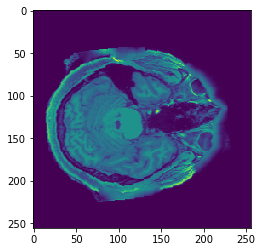

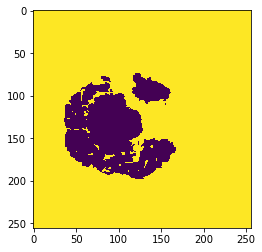

In [13]:
j = 3
plt.imshow(inputs['x'][1,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][1,0,:,:].numpy())
plt.show()

In [14]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [15]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [16]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(1,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,46, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [17]:
voxel_count = pd.read_csv('/cbi/hcp/hcp_seg/brain_segmentation/segment_counts.csv')

In [18]:
wts_num = np.mean(np.array(voxel_count.iloc[:,available_segments]),axis = 0)

In [19]:
wts_torch = Variable(torch.from_numpy(wts_num)).cuda()

In [20]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 1):
    preds = F.softmax(scores)
    N, C, sh1, sh2 = true.size()
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     print(wts)
    mean = 1/torch.pow(mean,p)
#     print(wts.size())
#     print(mean)
#     wts = torch.clamp(wts,0,0.1)
    wts[:,:] = mean[None].repeat(N,1)
#     wts[:,-1] = 0
#     wts[wts == 0.1] = 0
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    #print(wts)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [21]:
def dice_score(true,scores, epsilon = 1e-7):
    N ,C, sh1, sh2 = true.size()
    true = true.view(N,C,-1)
    #print(true.size())
    preds = F.softmax(scores)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*46
    for i in range(46):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
        
#     class_0_pred_seg = (pred_class == 0).data.type(torch.cuda.FloatTensor)
#     class_1_pred_seg = (pred_class == 1).data.type(torch.cuda.FloatTensor)
#     class_2_pred_seg = (pred_class == 2).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        #print(type(truth))
        #print(truth[:,int(idx),:].size())
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*46
    for i in range(46):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
#     dice_score_class_0 = torch.mean(2*(numerator(true,class_0_pred_seg,0))/(denominator(true,class_0_pred_seg,0)))
#     dice_score_class_1 = torch.mean(2*(numerator(true,class_1_pred_seg,1))/(denominator(true,class_1_pred_seg,1)))
#     dice_score_class_2 = torch.mean(2*(numerator(true,class_2_pred_seg,2))/(denominator(true,class_2_pred_seg,2)))
    
#    return (dice_score_class_0,dice_score_class_1, dice_score_class_2)
    return dice_class_score
    

In [25]:
import time
def train_model(model, optimizer, dataloader, data_sizes, batch_size, num_epochs = 100, verbose = False):
    since = time.time()
    best_loss = np.inf
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(46)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*46
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).type(torch.FloatTensor).cuda()
                y = Variable(y).type(torch.FloatTensor).cuda()
                
                output = model(x)
                loss = dice_loss_2(y, output,wts_torch)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    #scheduler.step()
                running_loss += loss.data[0] * batch_size
                dice_score_batch = dice_score(y,output)

                for j in range(46):
                    run_class_scores[j] = run_class_scores[j] + dice_score_batch[j] * batch_size
            epoch_loss = running_loss/data_sizes[phase]
            loss_hist[phase].append(epoch_loss.item()) 
            for j in range(46):
                score = run_class_scores[j]/data_sizes[phase]
                dice_scores_of_all_class[j][phase].append(score.to(torch.device("cpu")).numpy())
            if verbose or i%1 == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}'.format(i,phase,epoch_loss))
                print('-'*10)
            
        if phase == 'validate' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict() 
        print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [26]:
model = Unet().cuda()
model = nn.DataParallel(model)
criterion = dice_loss_2

optimizer = optim.Adam(model.parameters(),lr = 5e-4)
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [27]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,12,
                                                                num_epochs = 60, verbose = True)

Epoch: 0, Phase: train, epoch loss: 1.0005
----------
Epoch: 0, Phase: validate, epoch loss: 1.0062
----------
0
Epoch: 1, Phase: train, epoch loss: 0.5498
----------
Epoch: 1, Phase: validate, epoch loss: 0.3976
----------
1
Epoch: 2, Phase: train, epoch loss: 0.3564
----------
Epoch: 2, Phase: validate, epoch loss: 0.3547
----------
2
Epoch: 3, Phase: train, epoch loss: 0.3416
----------
Epoch: 3, Phase: validate, epoch loss: 0.3514
----------
3
Epoch: 4, Phase: train, epoch loss: 0.3322
----------
Epoch: 4, Phase: validate, epoch loss: 0.3404
----------
4
Epoch: 5, Phase: train, epoch loss: 0.3279
----------
Epoch: 5, Phase: validate, epoch loss: 0.3813
----------
5
Epoch: 6, Phase: train, epoch loss: 0.3233
----------
Epoch: 6, Phase: validate, epoch loss: 0.3458
----------
6
Epoch: 7, Phase: train, epoch loss: 0.3209
----------
Epoch: 7, Phase: validate, epoch loss: 0.3312
----------
7
Epoch: 8, Phase: train, epoch loss: 0.3183
----------
Epoch: 8, Phase: validate, epoch loss: 0.3

In [28]:
torch.save(model.state_dict(), "model2")

In [29]:
def visualize1(image):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(46):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    #plt.title(title)
    #plt.imshow(masked[:,:].cpu().numpy())
    #print(torch.stack(img).size())
    return torch.stack(img).resize(46,1,256,256).cpu()

In [30]:
%matplotlib inline
def show(img):
    
    npimg = img.numpy()
    #print(npimg.shape)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

----------------------------------------------------------------------------------------------------
Ground Truth


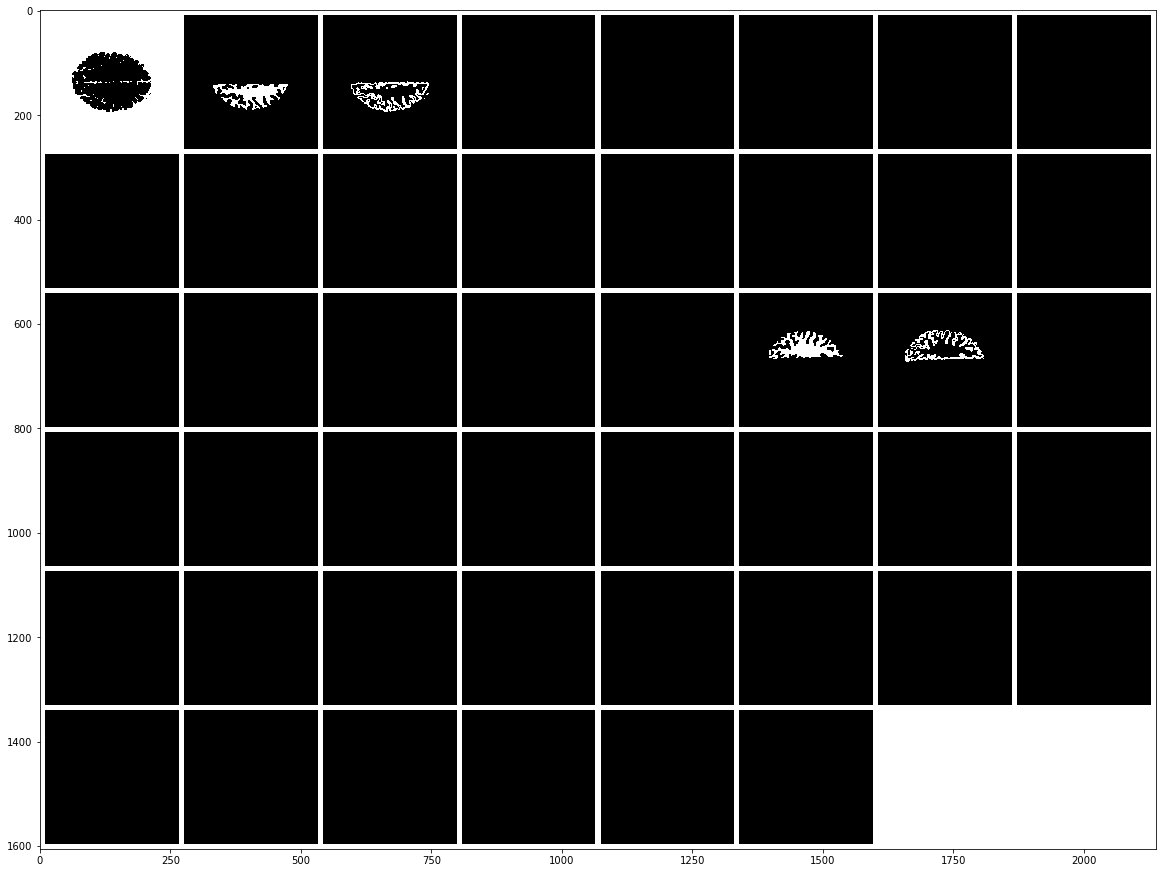

----------------------------------------------------------------------------------------------------
Prediction


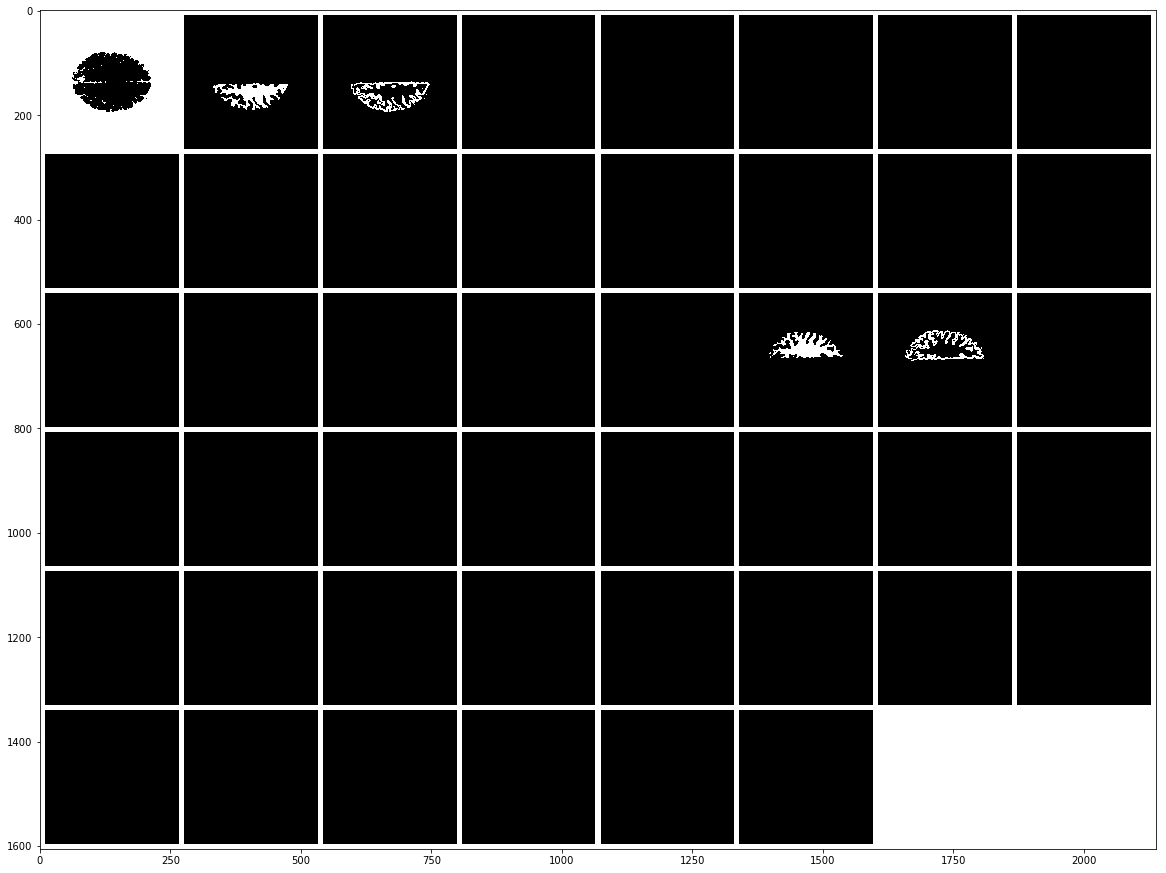

----------------------------------------------------------------------------------------------------
Ground Truth


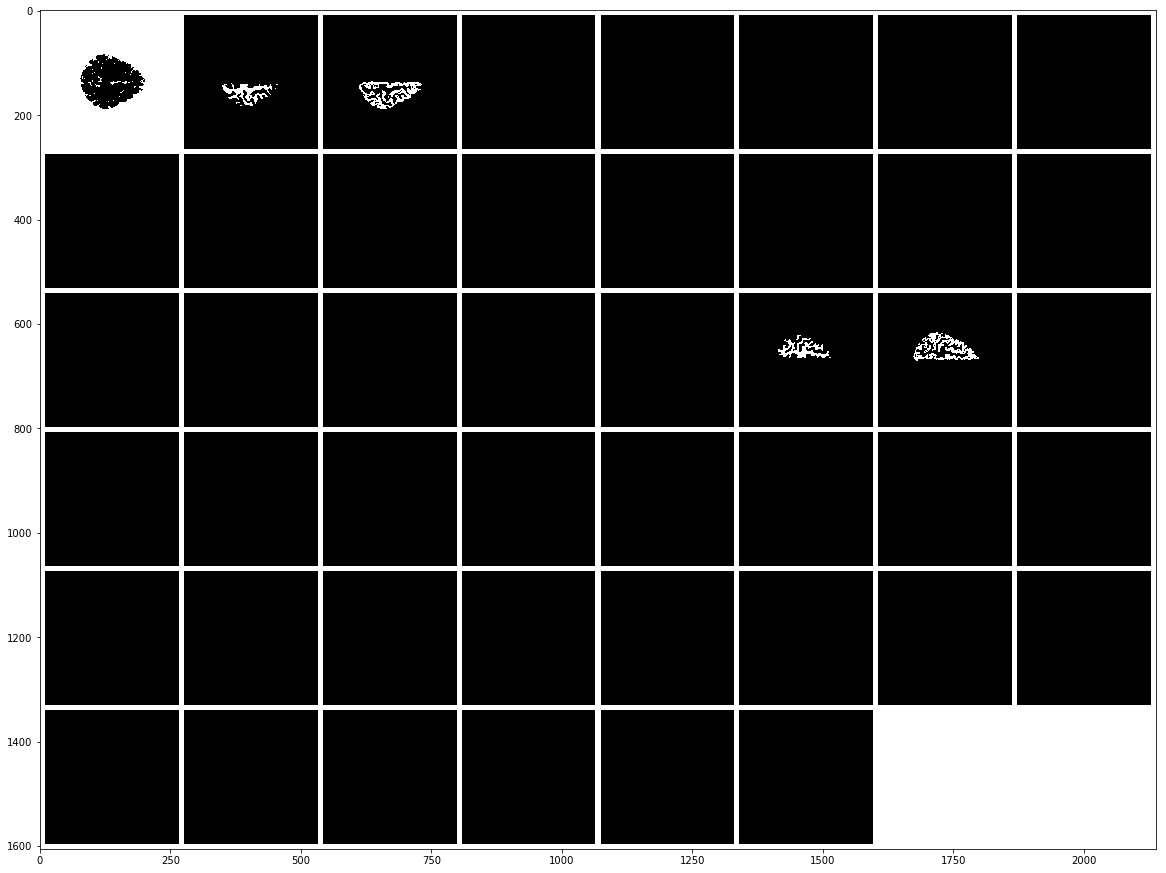

----------------------------------------------------------------------------------------------------
Prediction


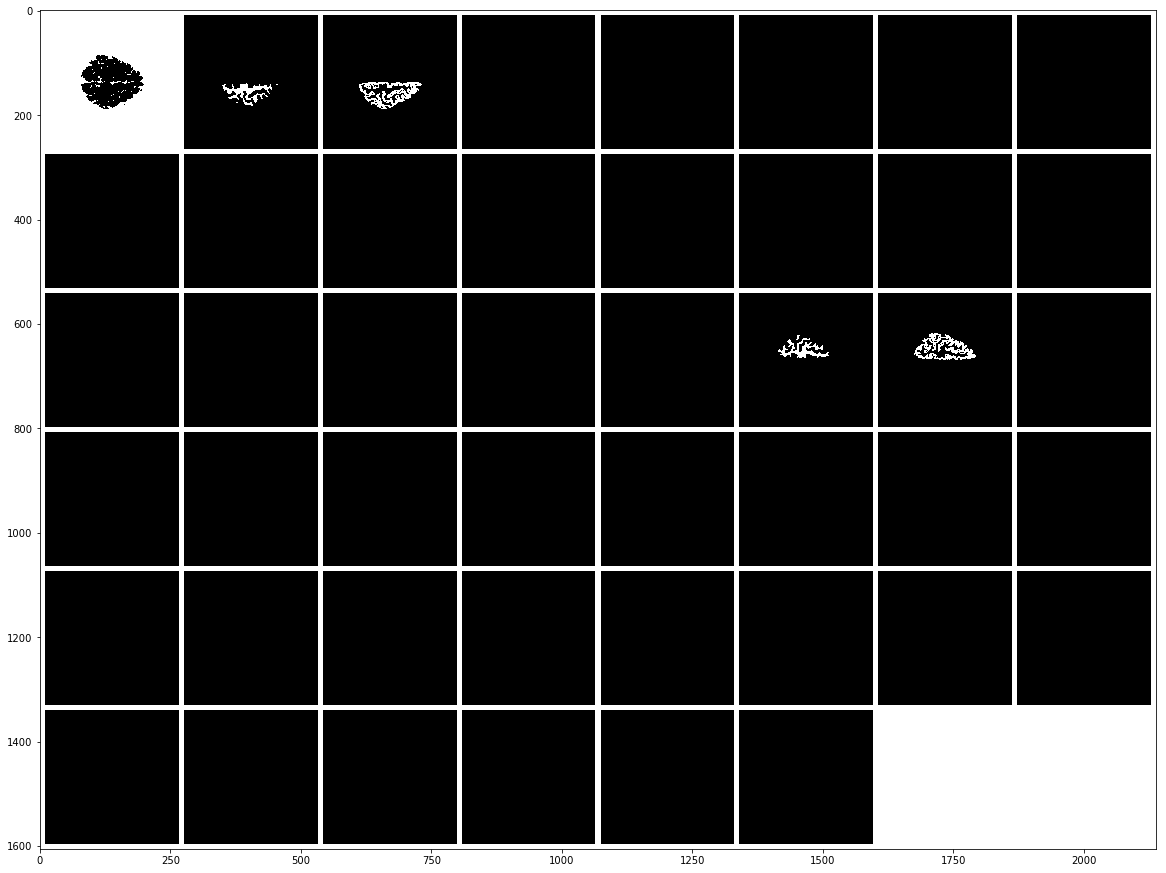

----------------------------------------------------------------------------------------------------
Ground Truth


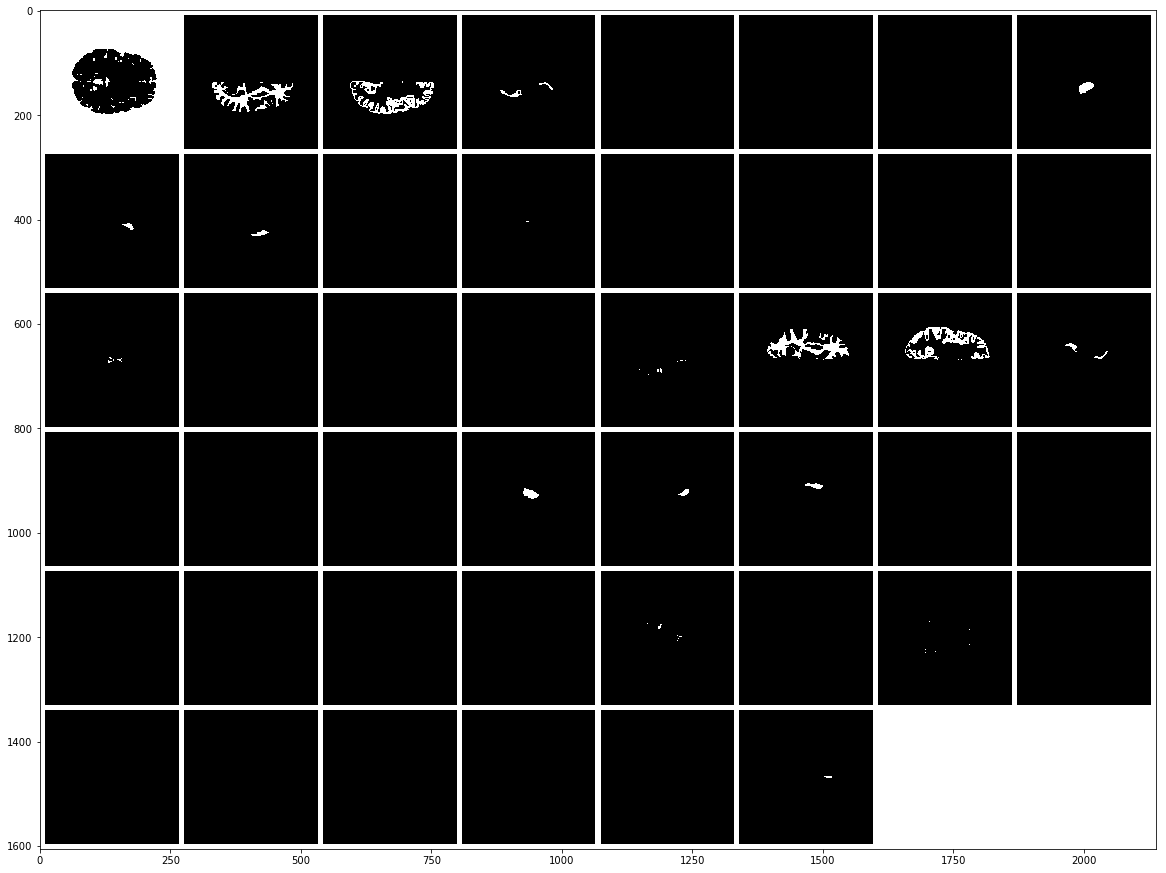

----------------------------------------------------------------------------------------------------
Prediction


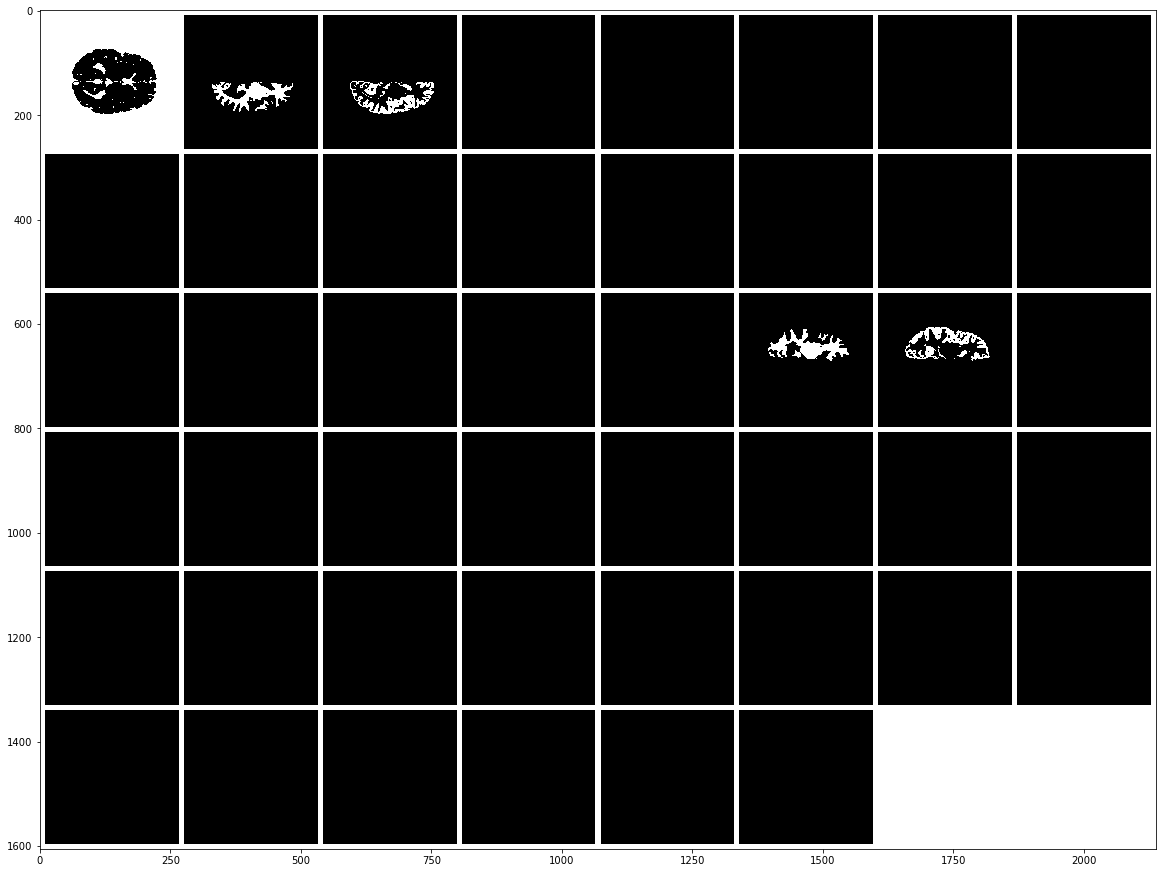

----------------------------------------------------------------------------------------------------
Ground Truth


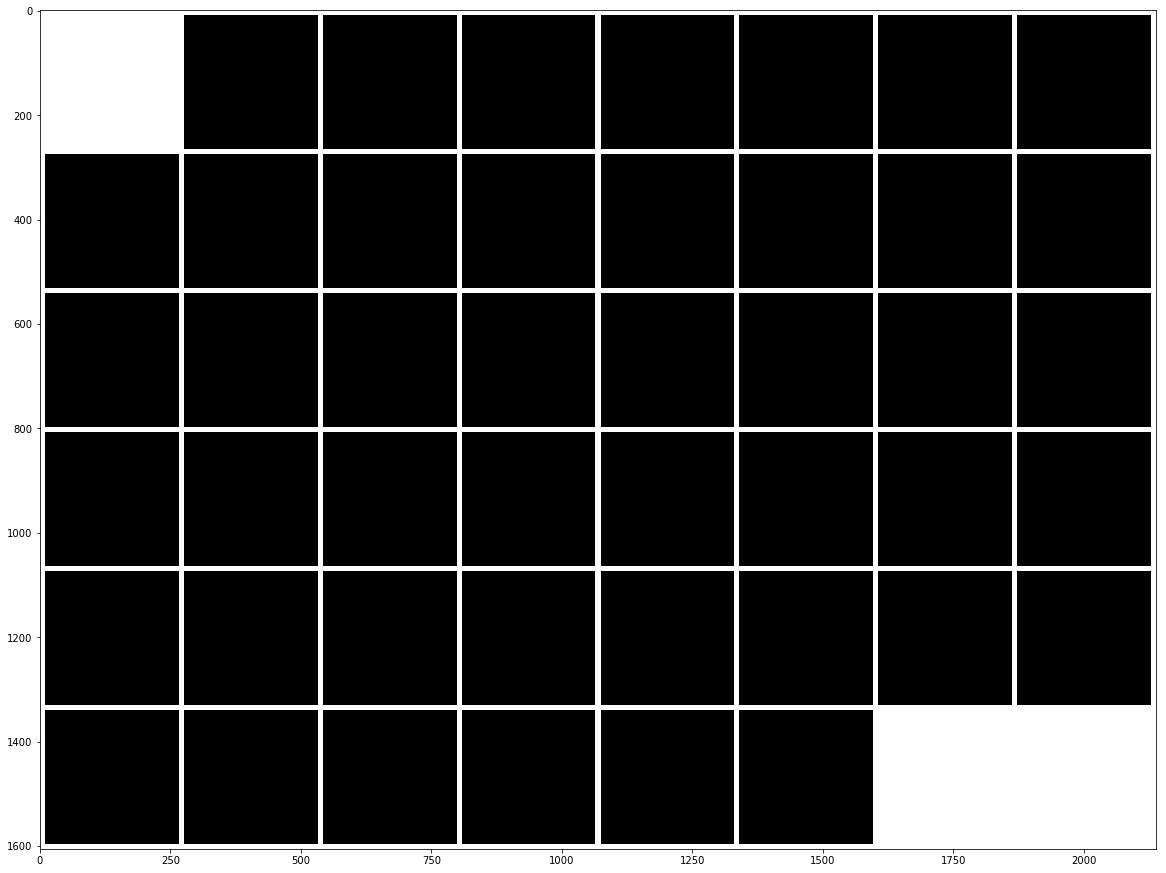

----------------------------------------------------------------------------------------------------
Prediction


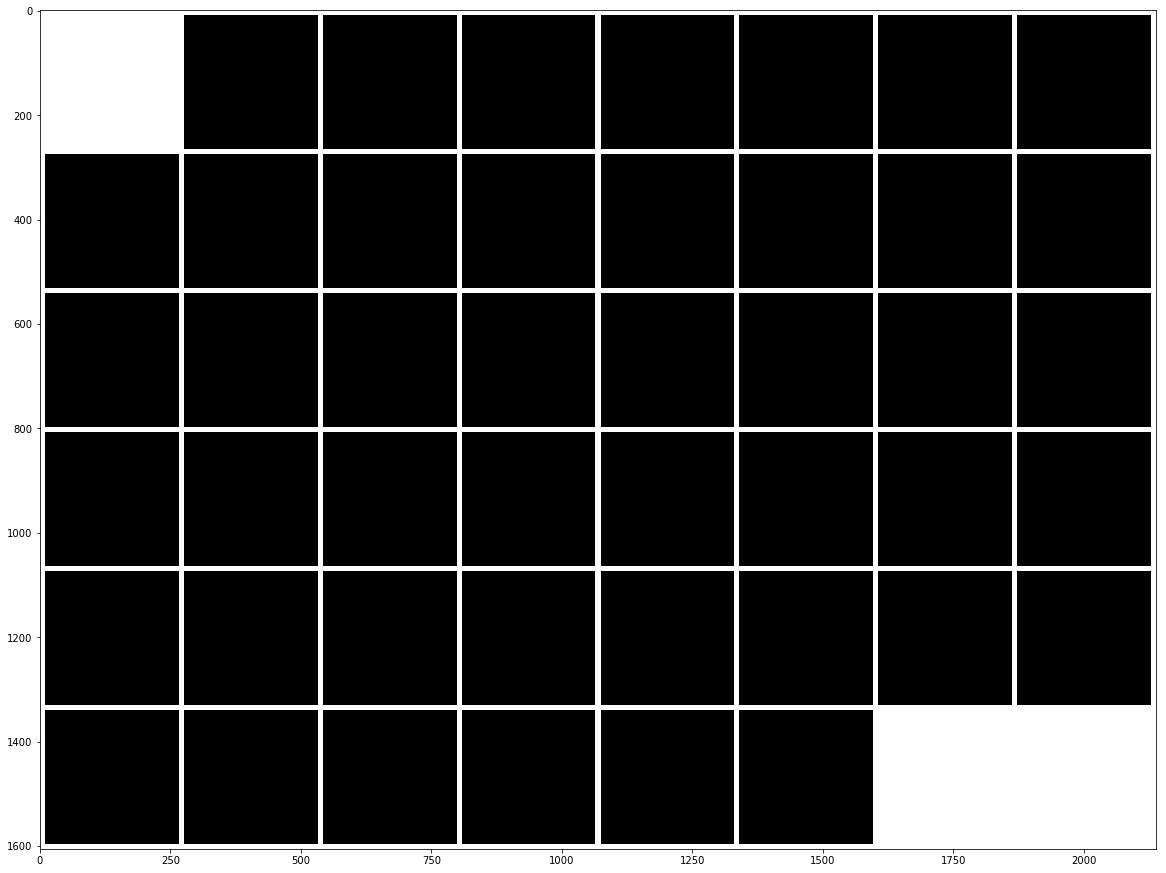

----------------------------------------------------------------------------------------------------
Ground Truth


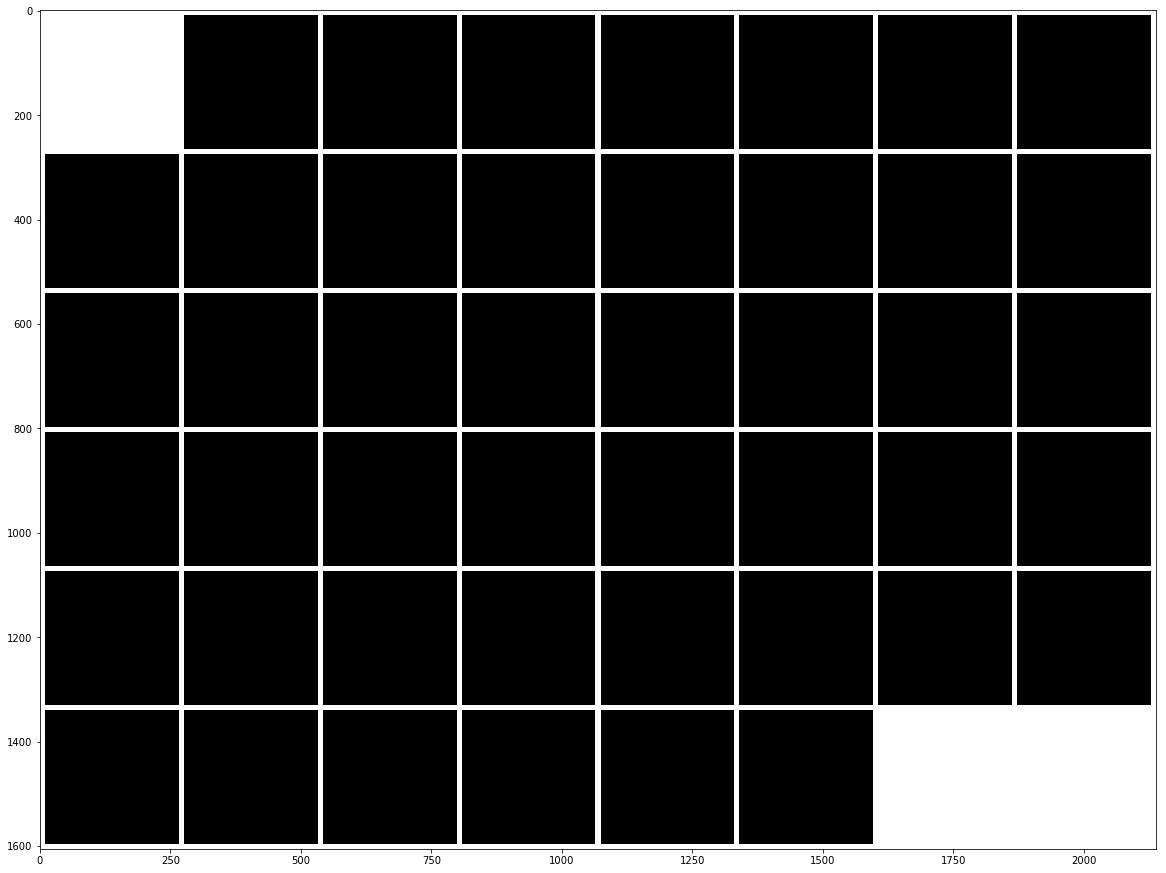

----------------------------------------------------------------------------------------------------
Prediction


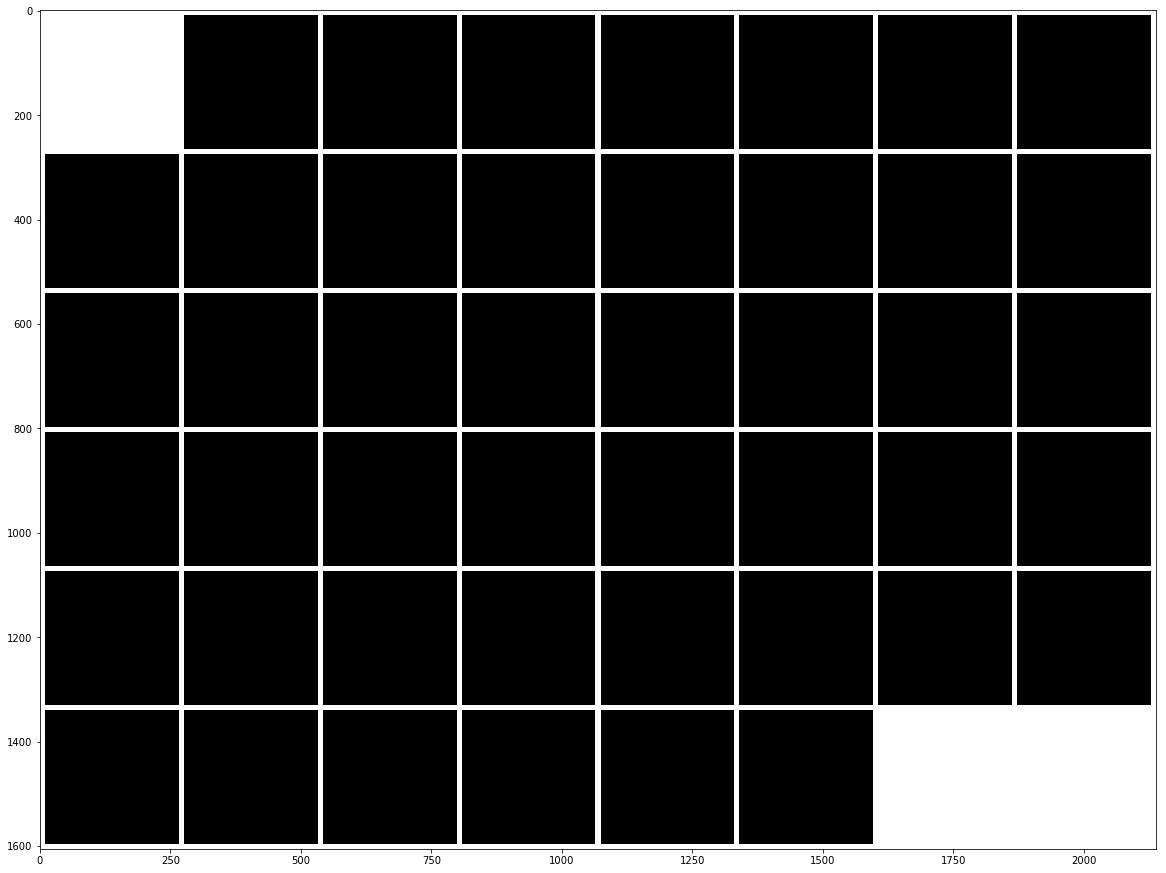

----------------------------------------------------------------------------------------------------
Ground Truth


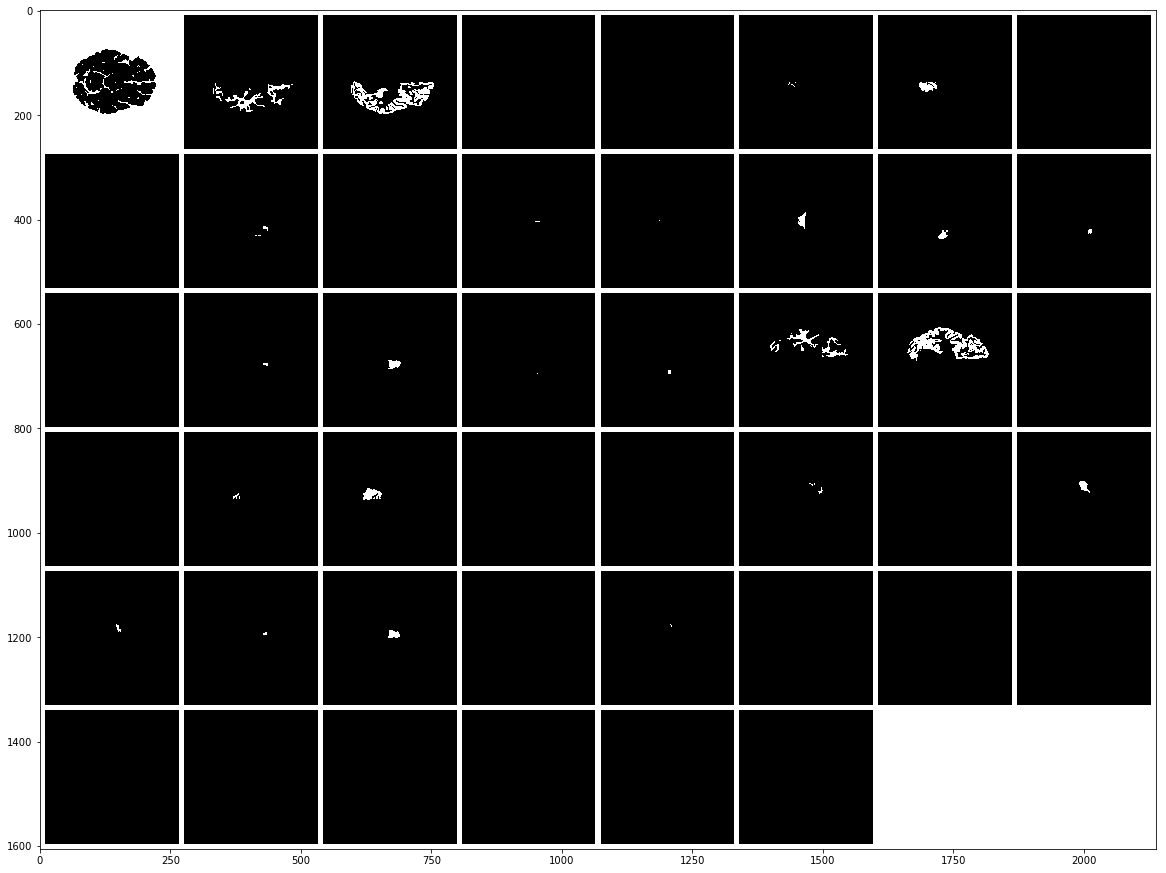

----------------------------------------------------------------------------------------------------
Prediction


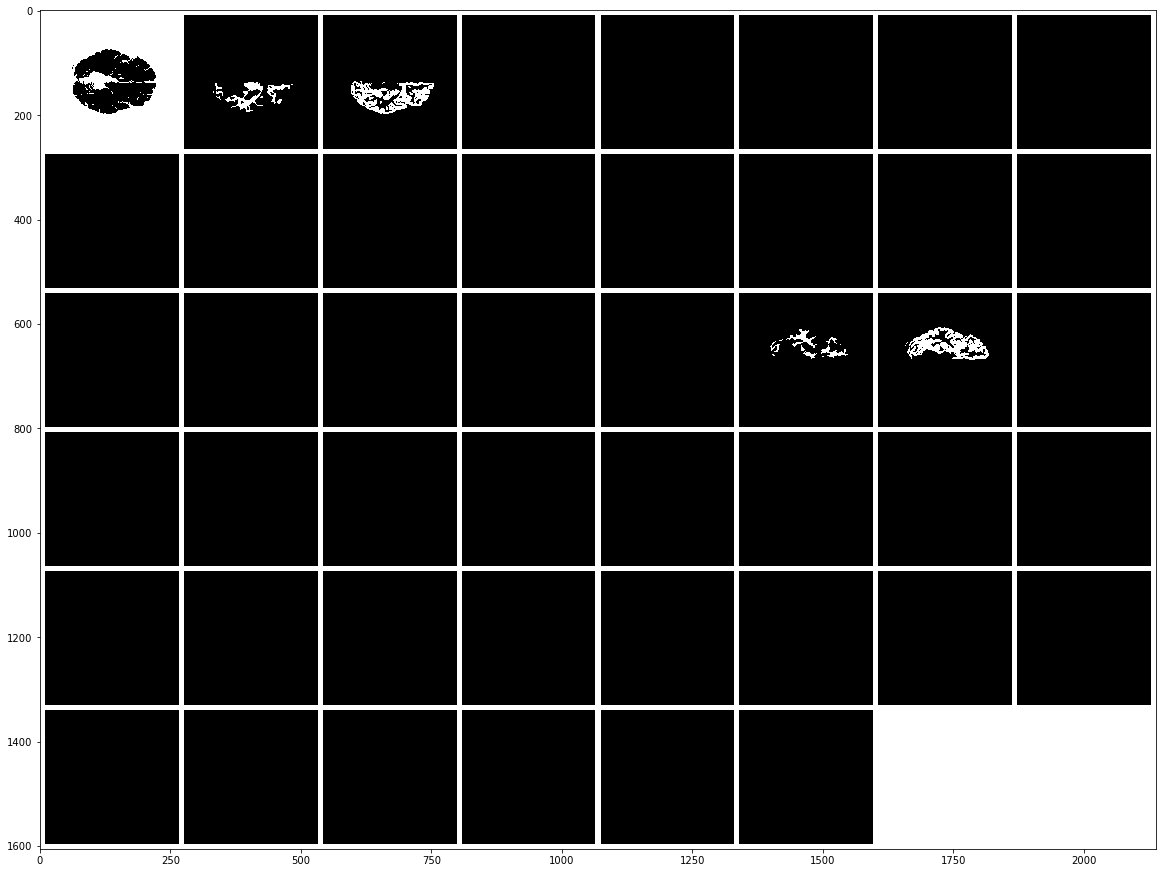

----------------------------------------------------------------------------------------------------
Ground Truth


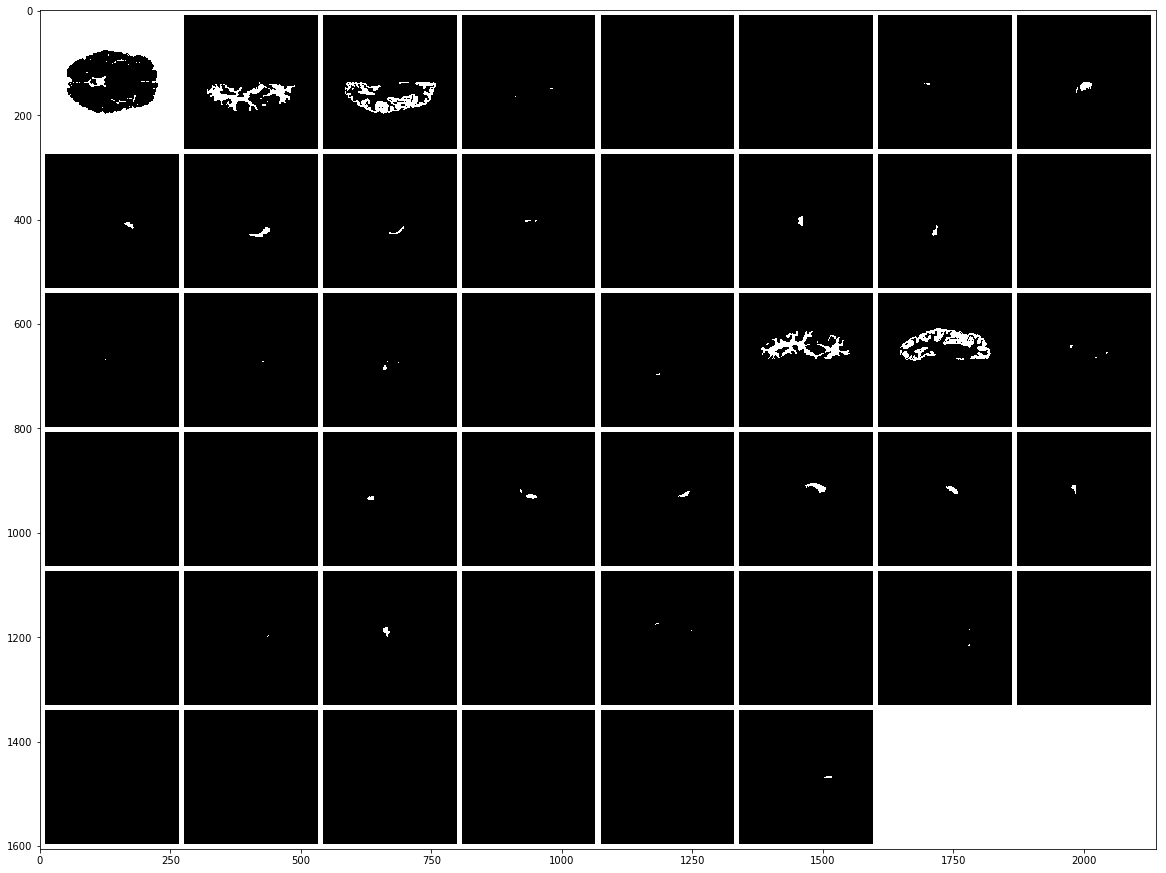

----------------------------------------------------------------------------------------------------
Prediction


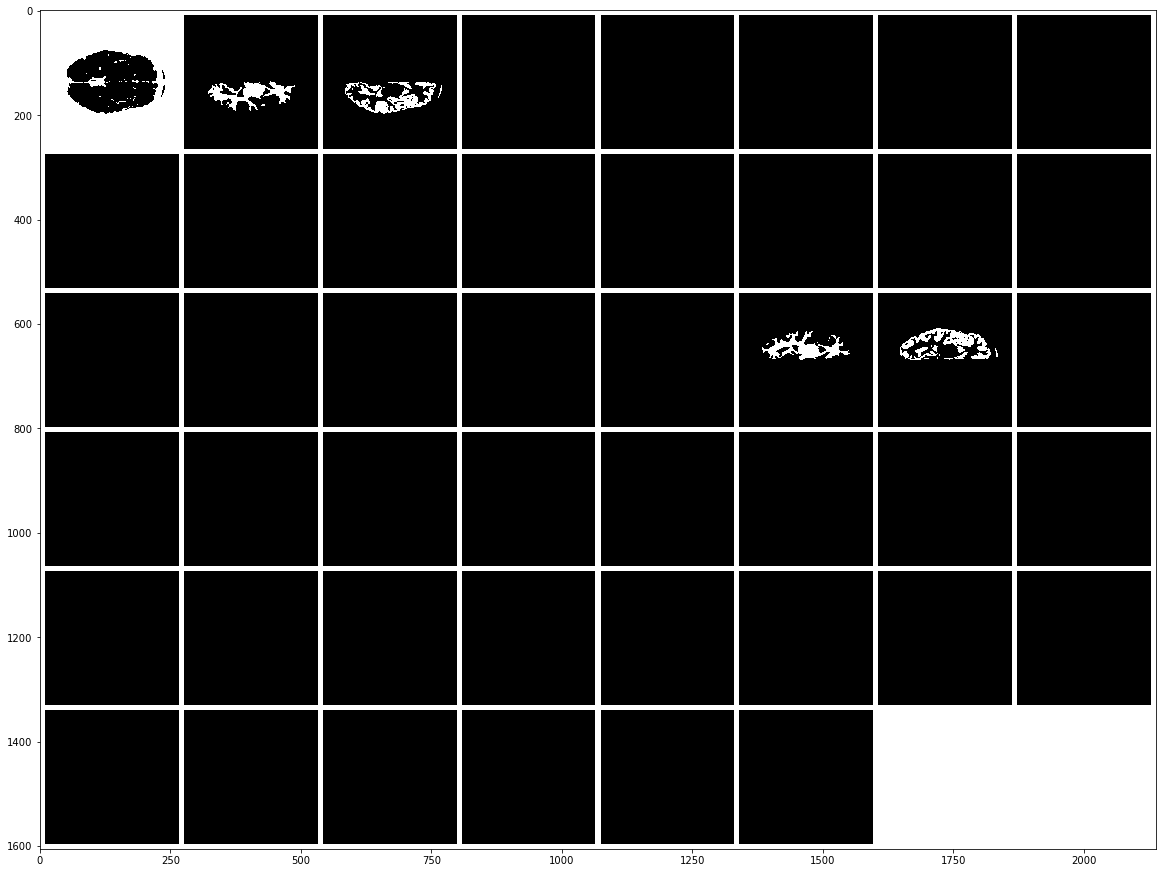

----------------------------------------------------------------------------------------------------
Ground Truth


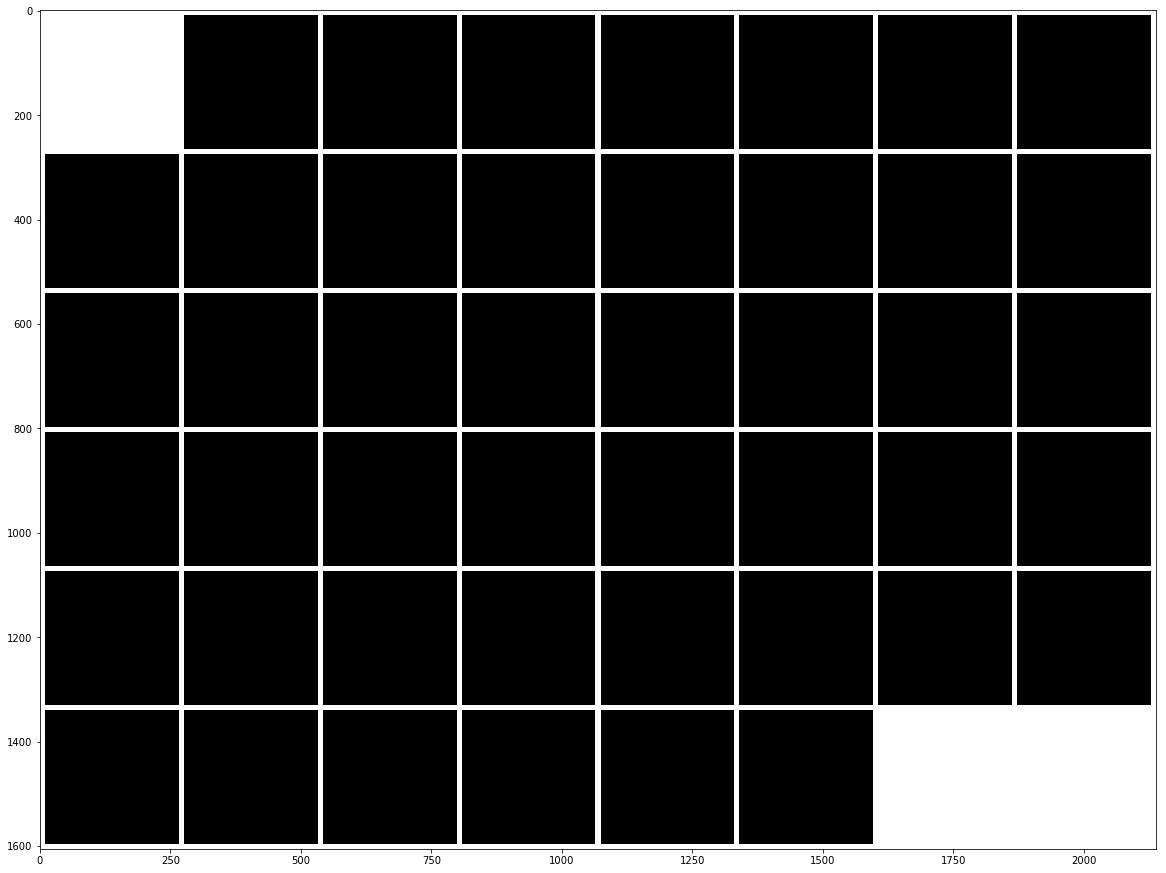

----------------------------------------------------------------------------------------------------
Prediction


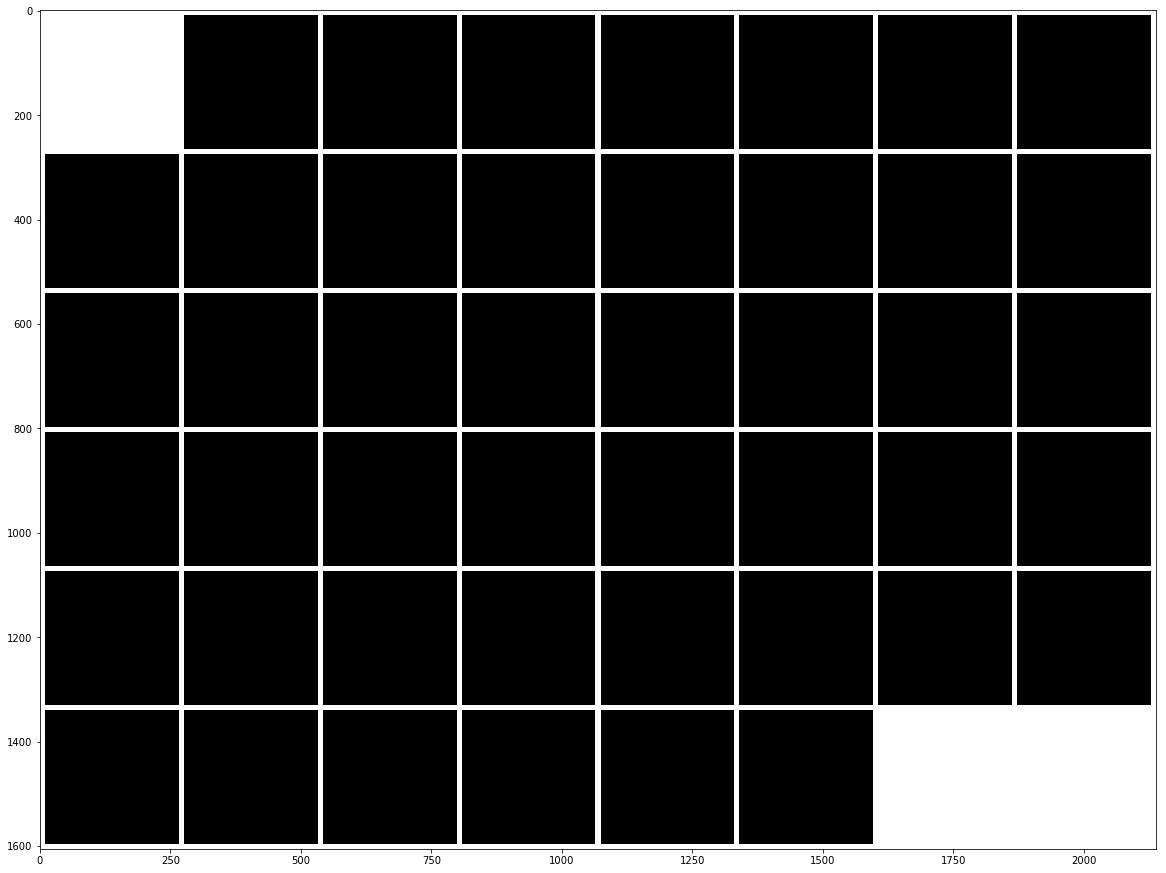

----------------------------------------------------------------------------------------------------
Ground Truth


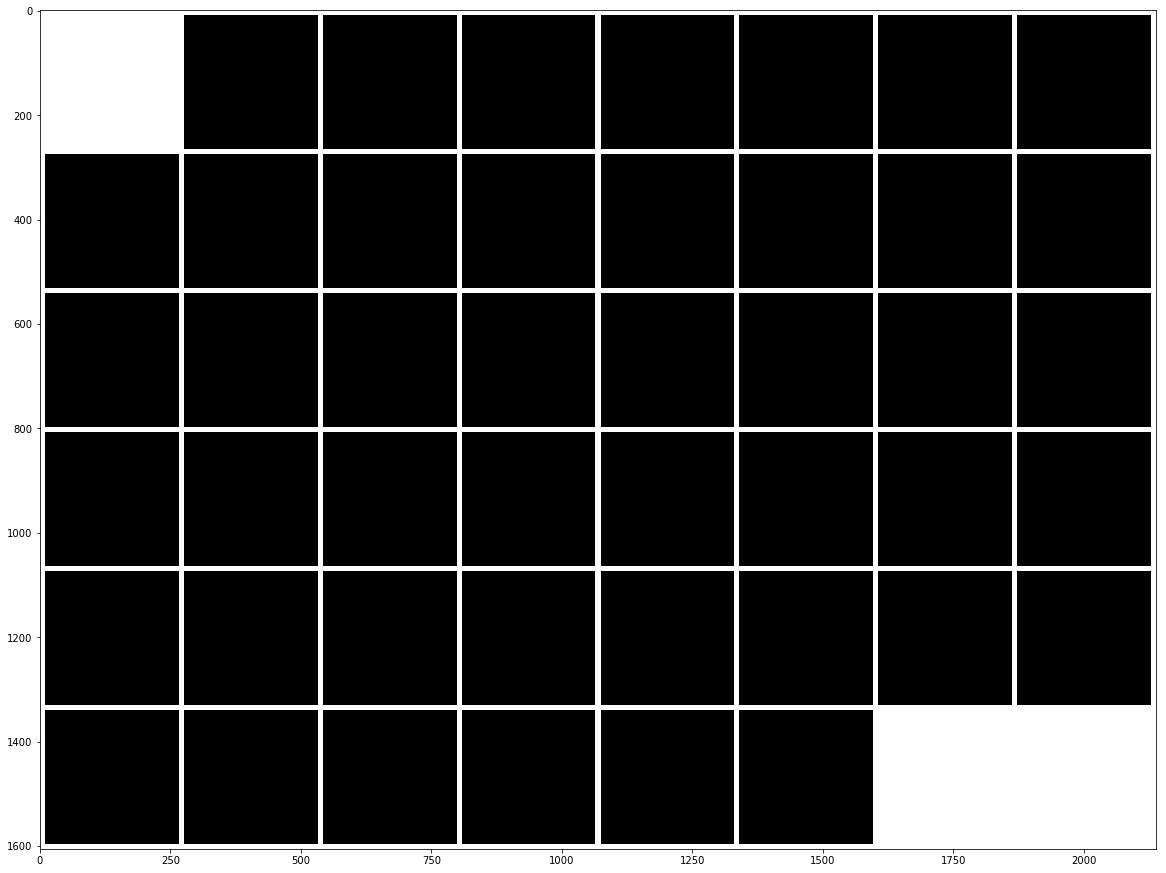

----------------------------------------------------------------------------------------------------
Prediction


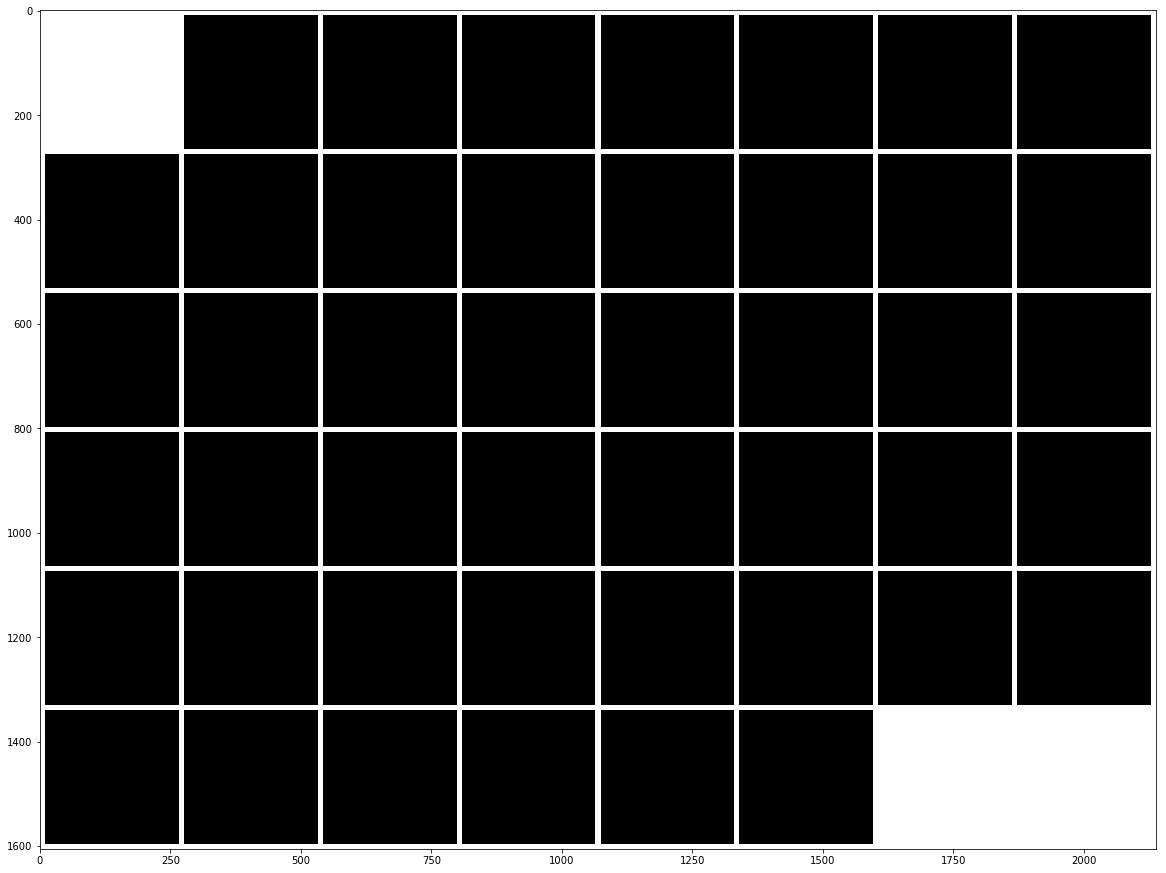

----------------------------------------------------------------------------------------------------
Ground Truth


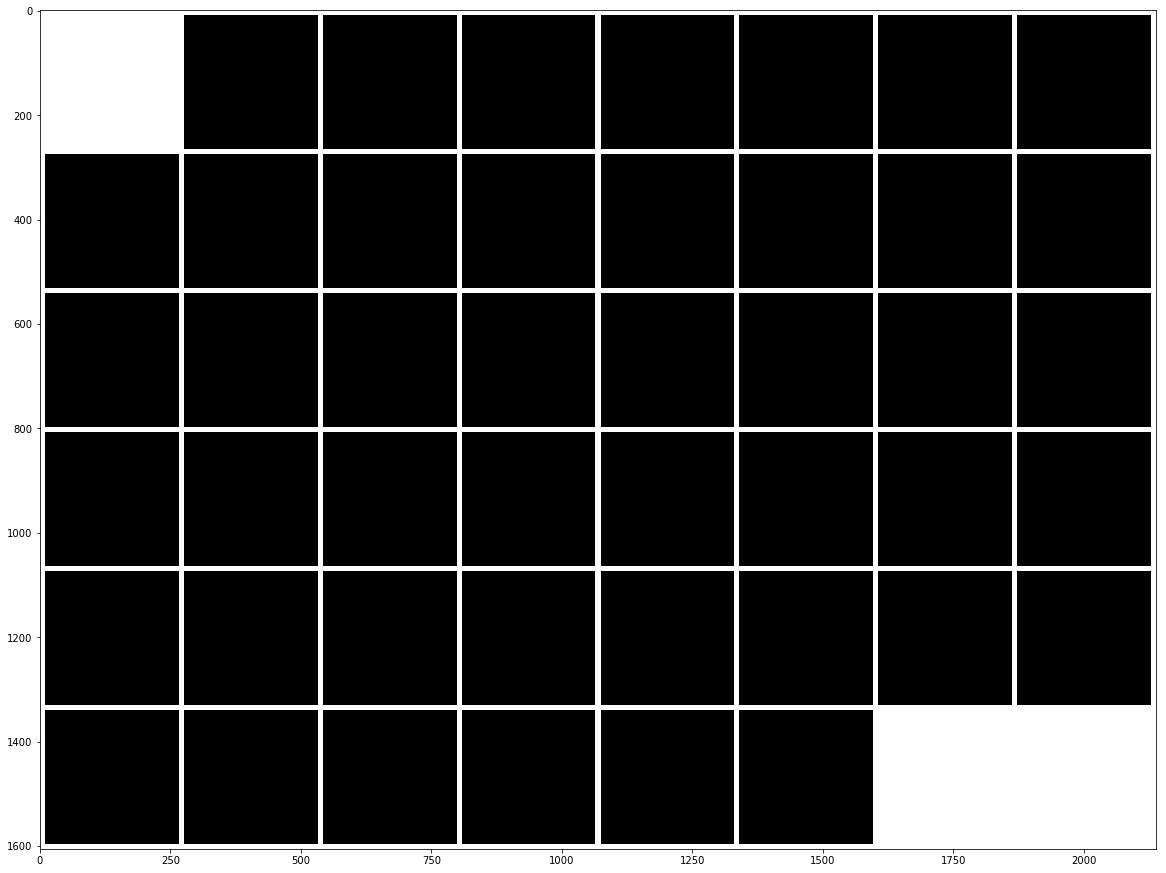

----------------------------------------------------------------------------------------------------
Prediction


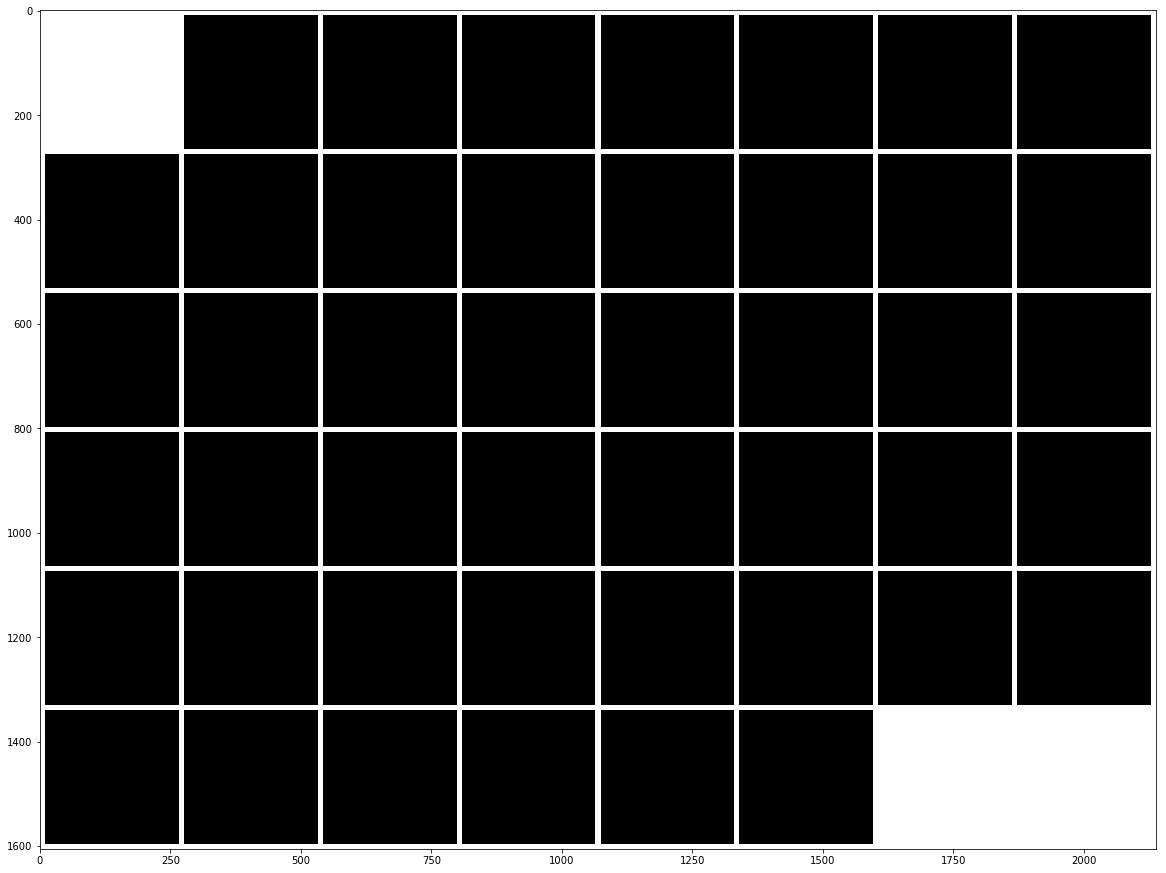

----------------------------------------------------------------------------------------------------
Ground Truth


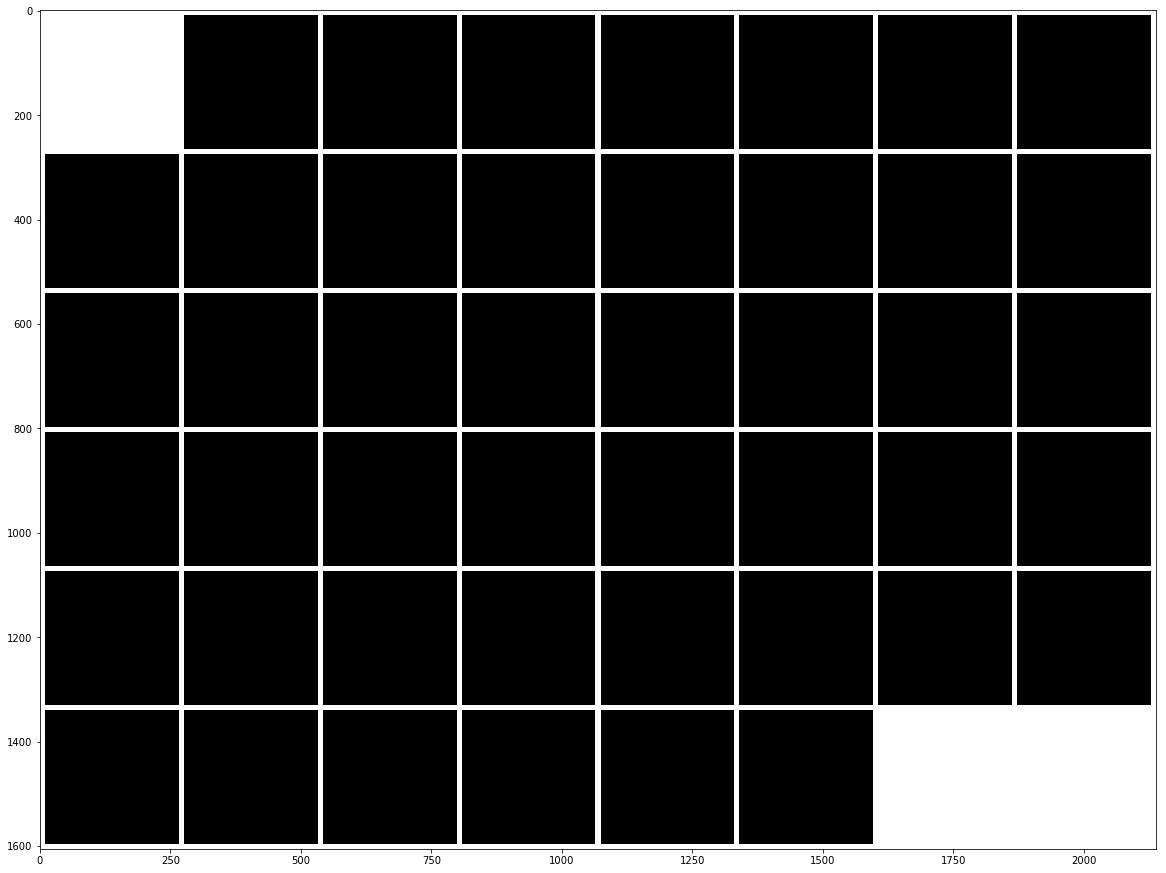

----------------------------------------------------------------------------------------------------
Prediction


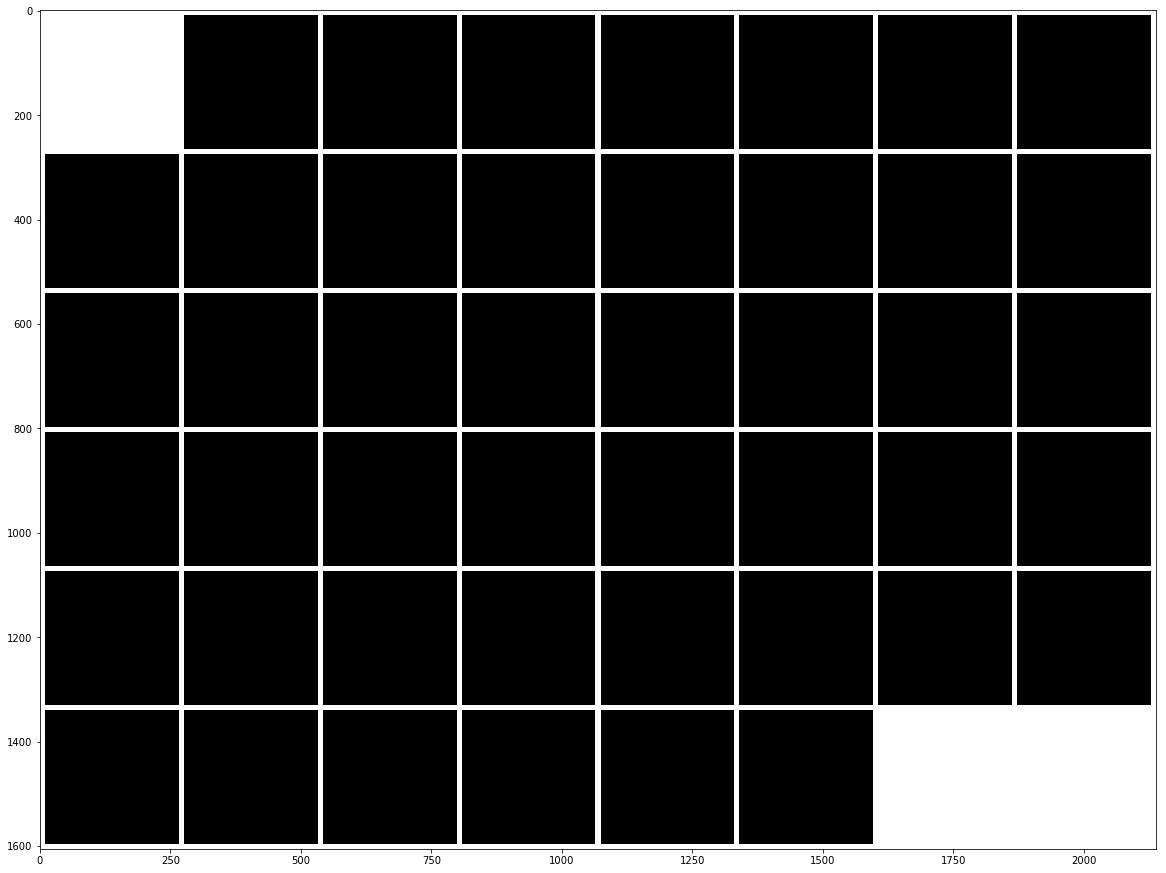

In [33]:
data = next(iter(dataloader["validate"]))
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)
for i in range(11):
    print('-'*100)
    print('Ground Truth')
    abc = data['y'][i,:,:,:]
    bcd = abc.resize(46,1,256,256)
    show(make_grid(bcd,padding=10,pad_value=1)) 
    print('-'*100)
    print('Prediction')
    show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))
    
    

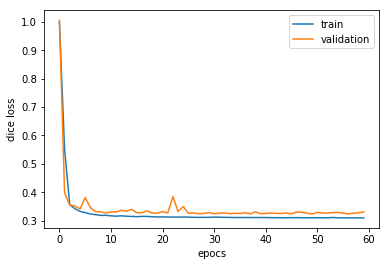

In [34]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label = "validation")
plt.ylabel("dice loss")
plt.xlabel("epocs")
plt.legend()
plt.show()

----------------------------------------------------------------------------------------------------
Ground Truth


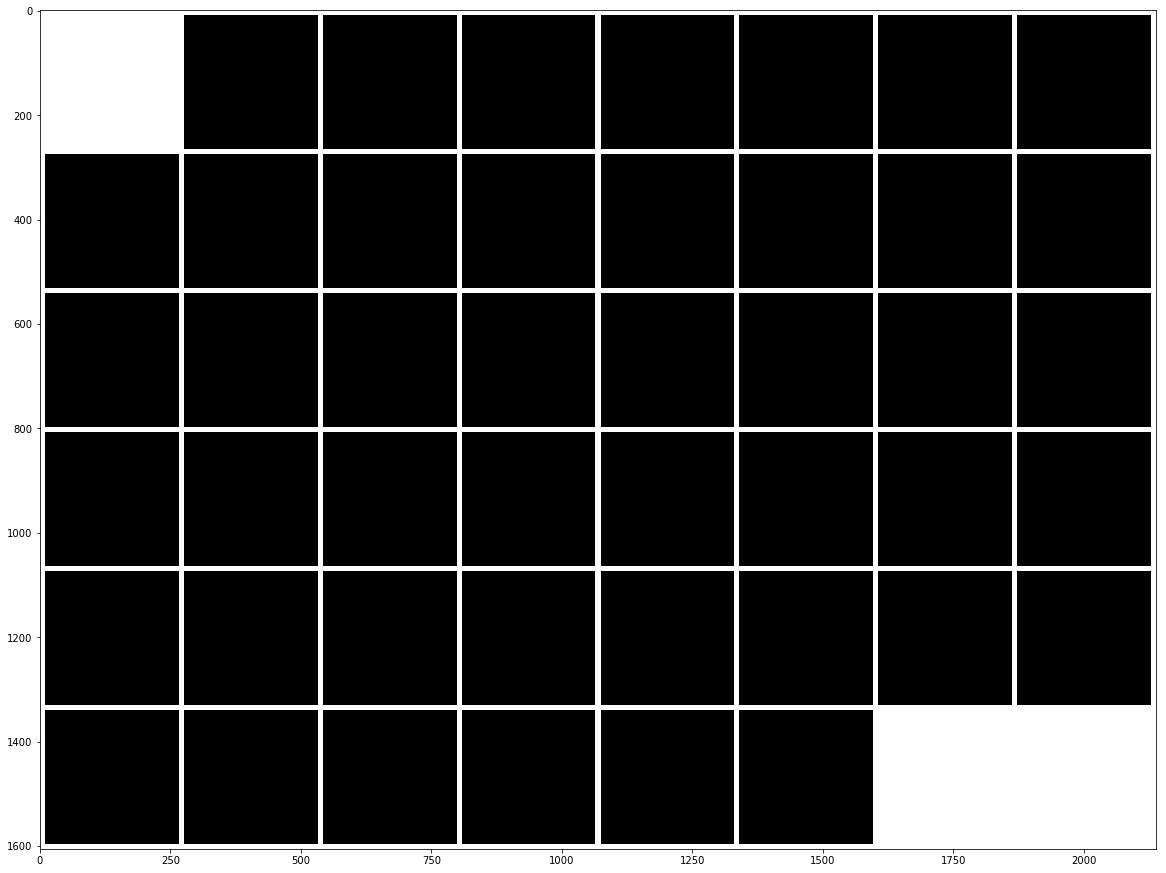

----------------------------------------------------------------------------------------------------
Prediction


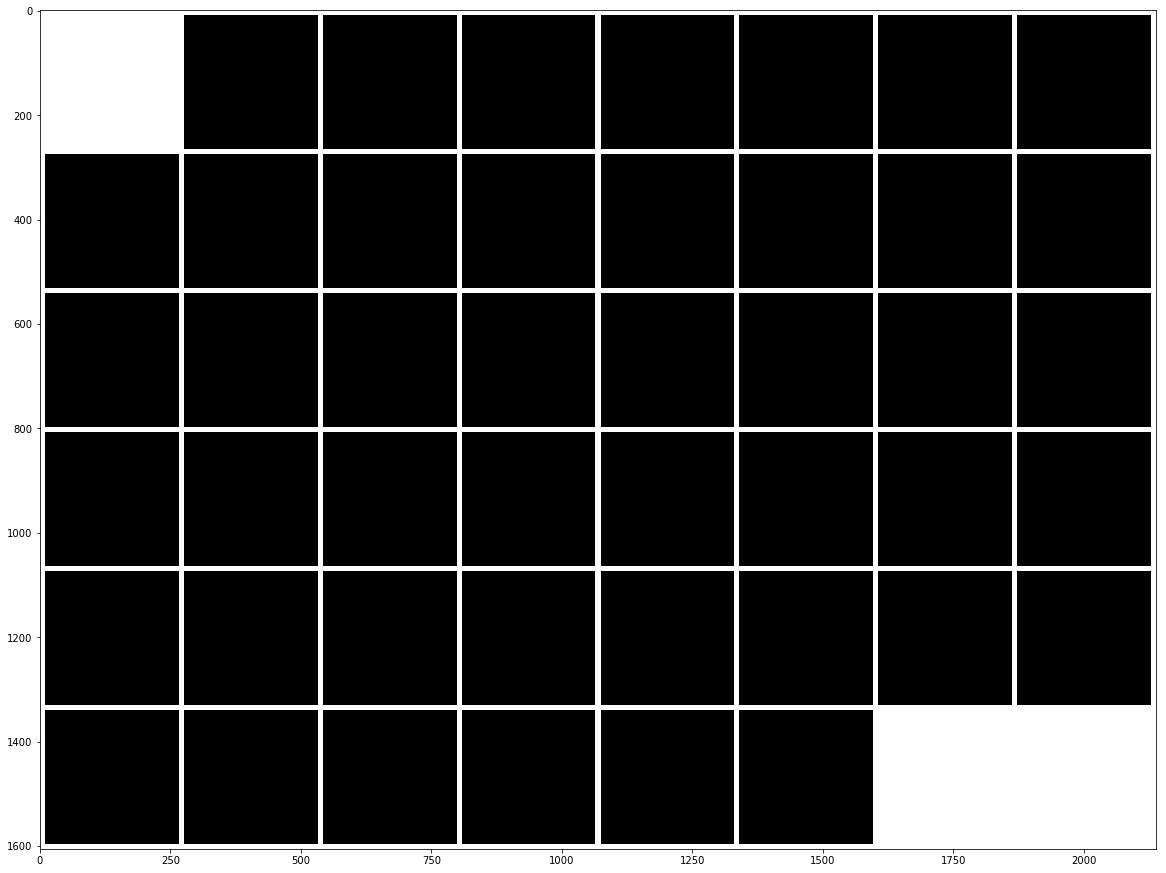

----------------------------------------------------------------------------------------------------
Ground Truth


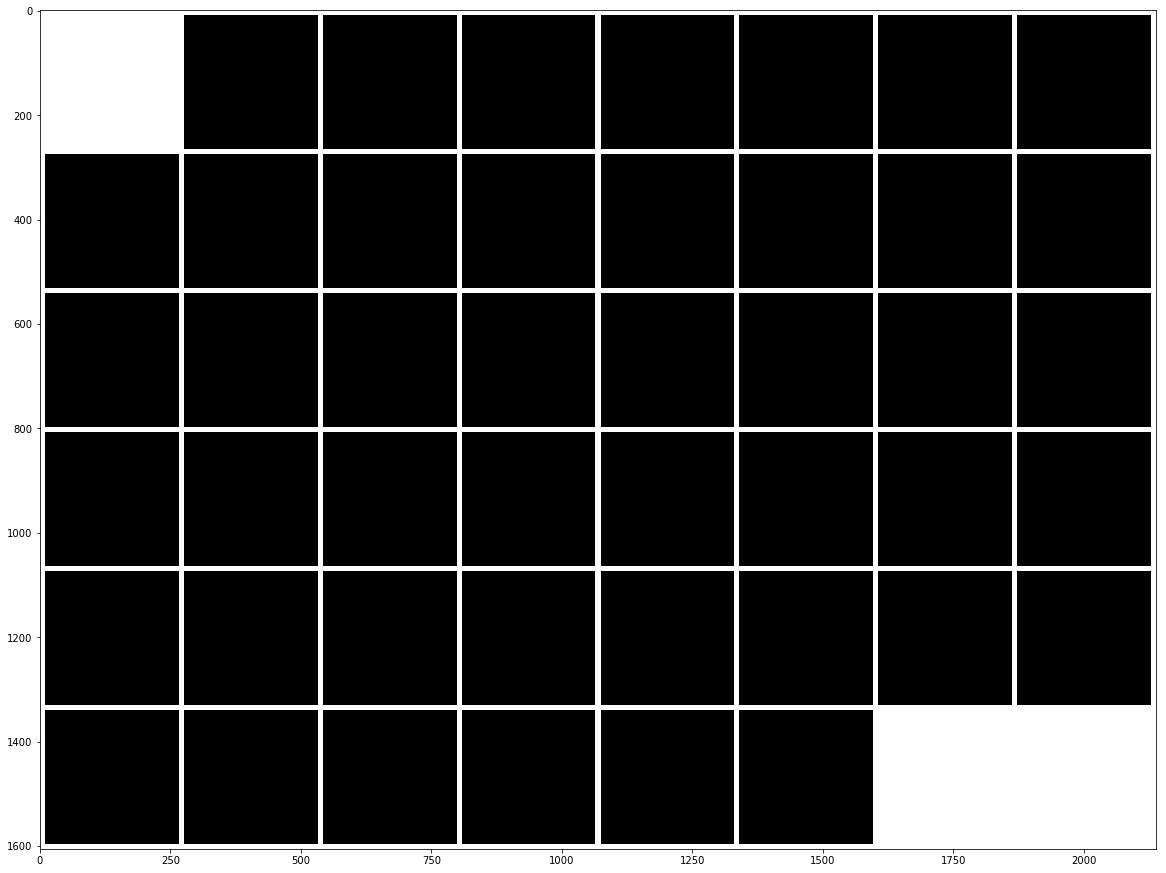

----------------------------------------------------------------------------------------------------
Prediction


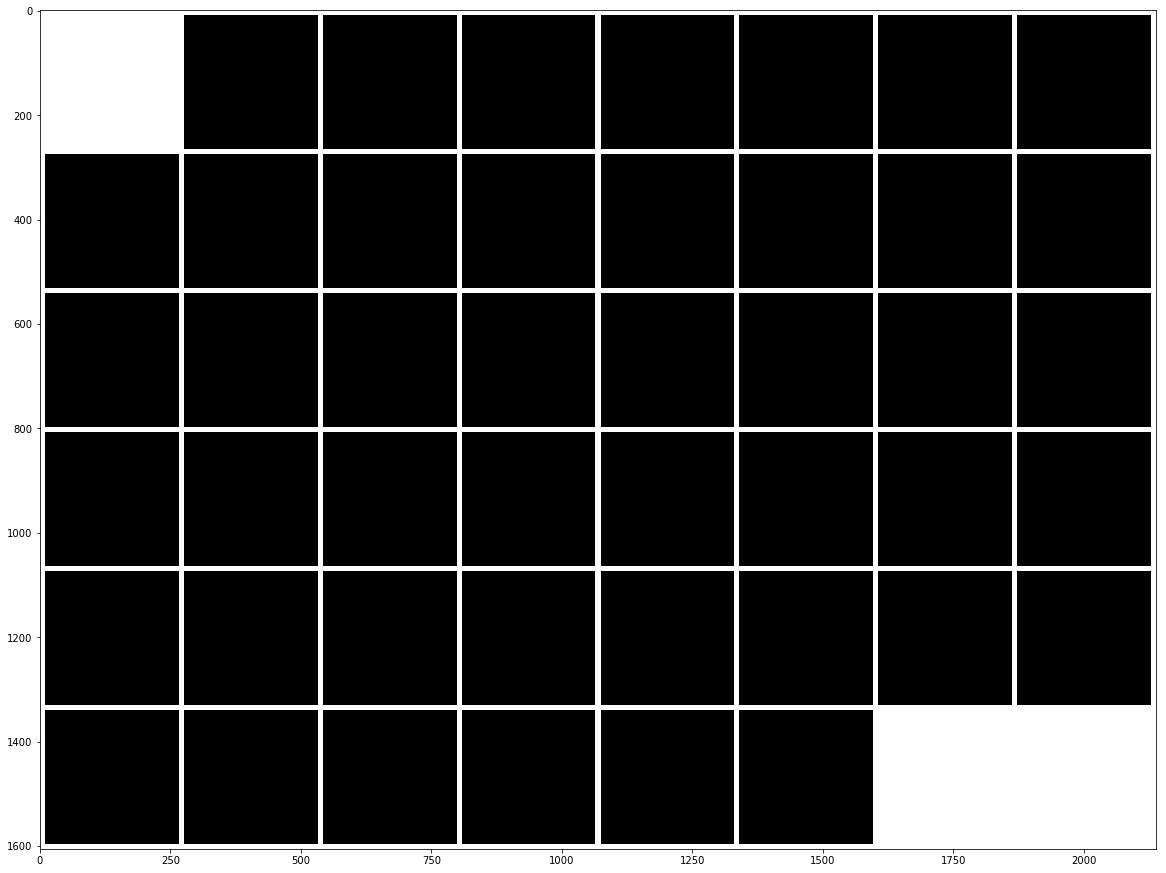

----------------------------------------------------------------------------------------------------
Ground Truth


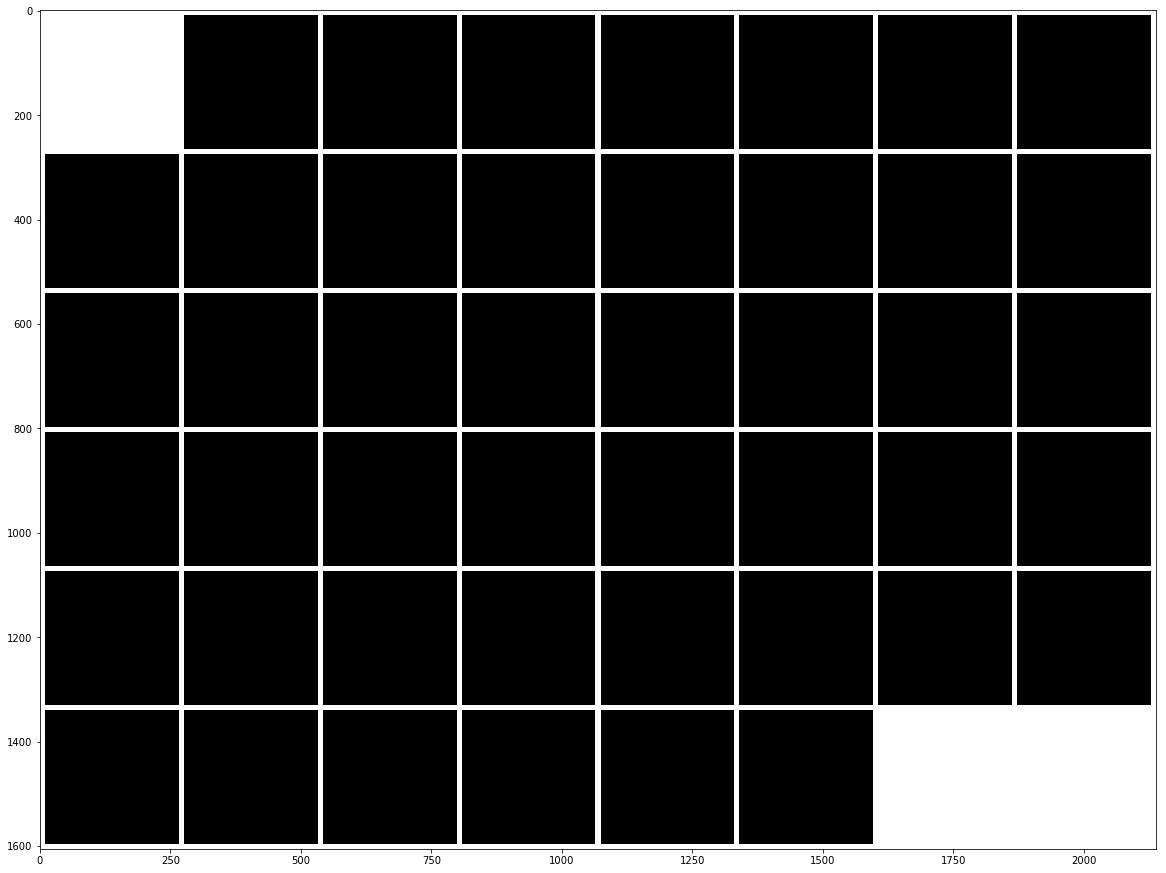

----------------------------------------------------------------------------------------------------
Prediction


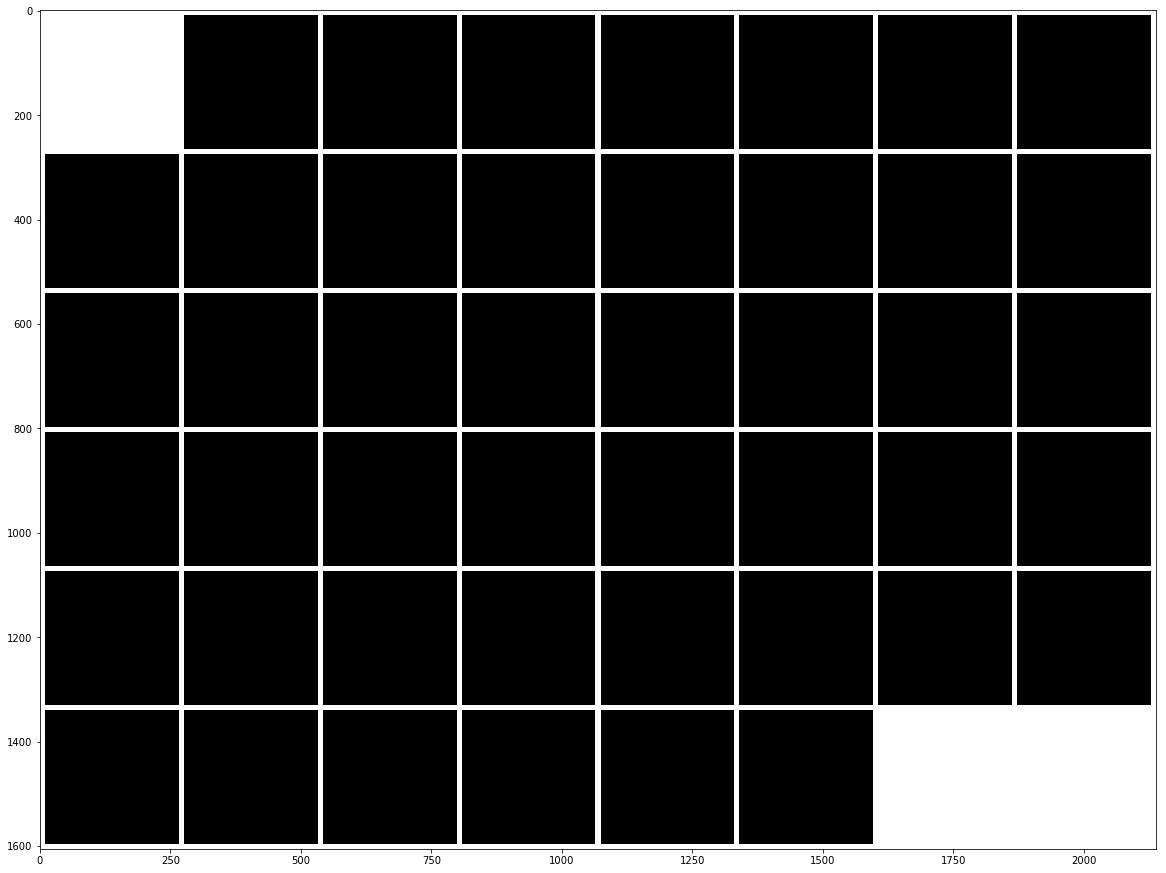

----------------------------------------------------------------------------------------------------
Ground Truth


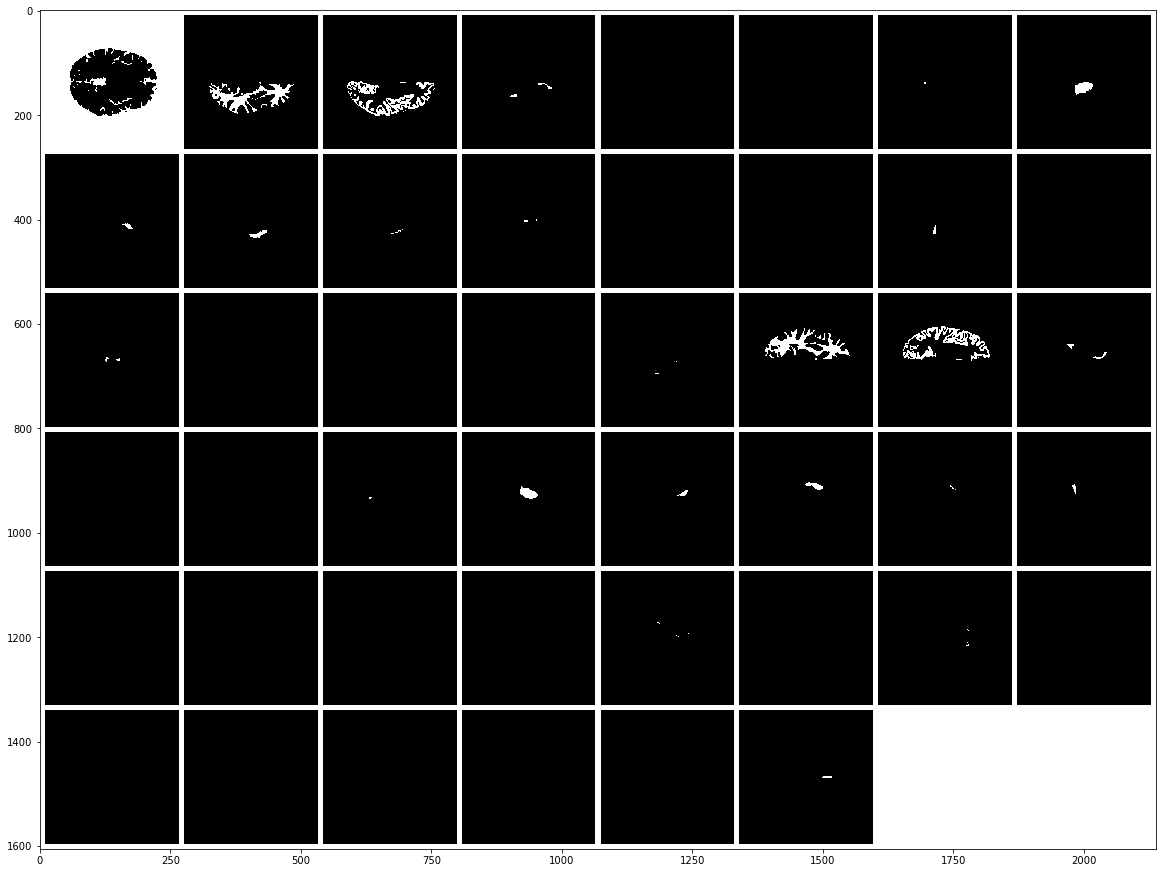

----------------------------------------------------------------------------------------------------
Prediction


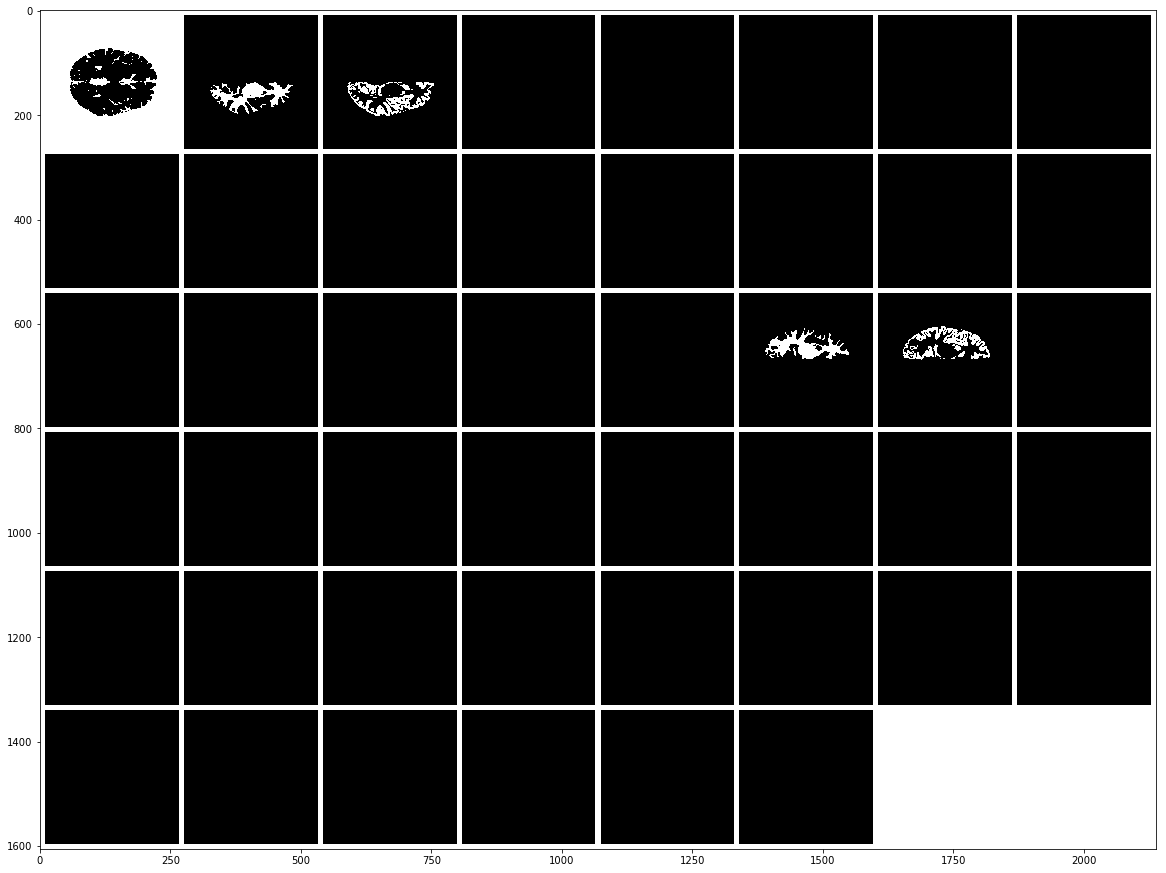

----------------------------------------------------------------------------------------------------
Ground Truth


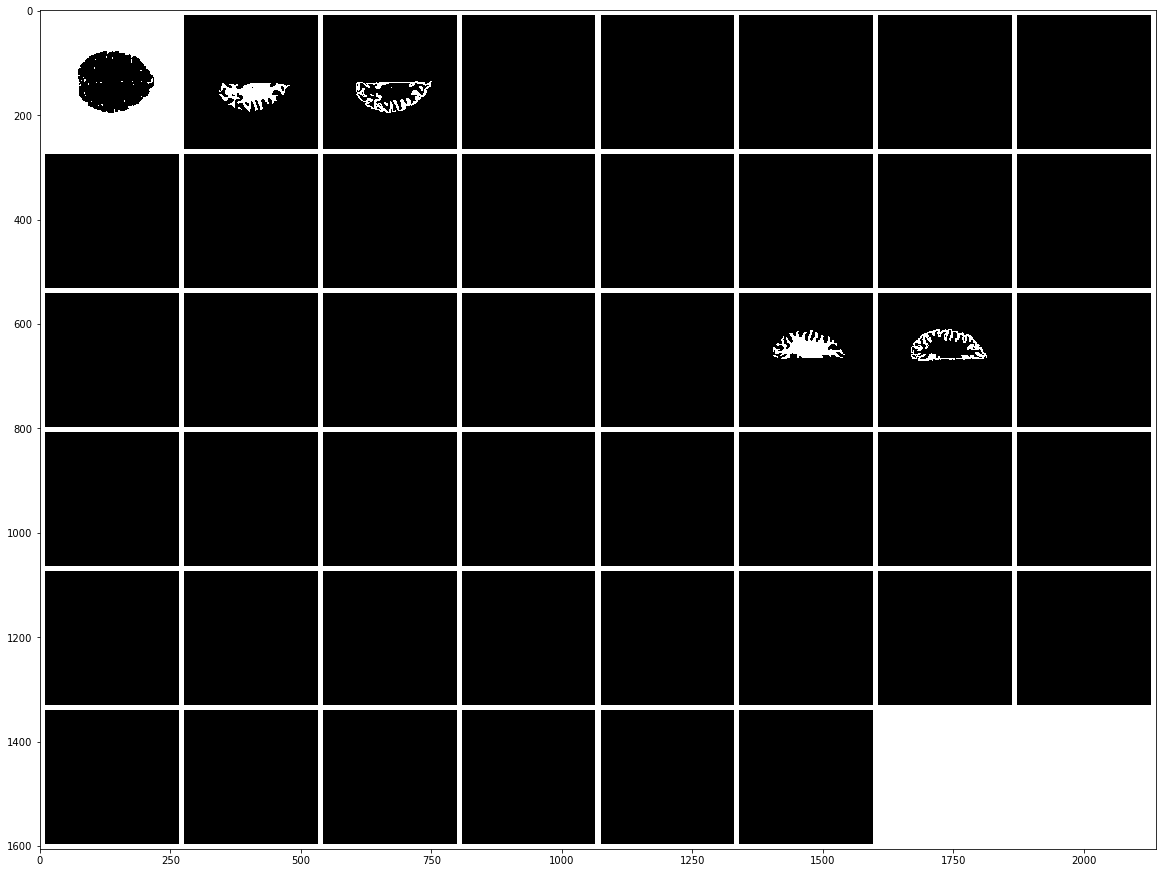

----------------------------------------------------------------------------------------------------
Prediction


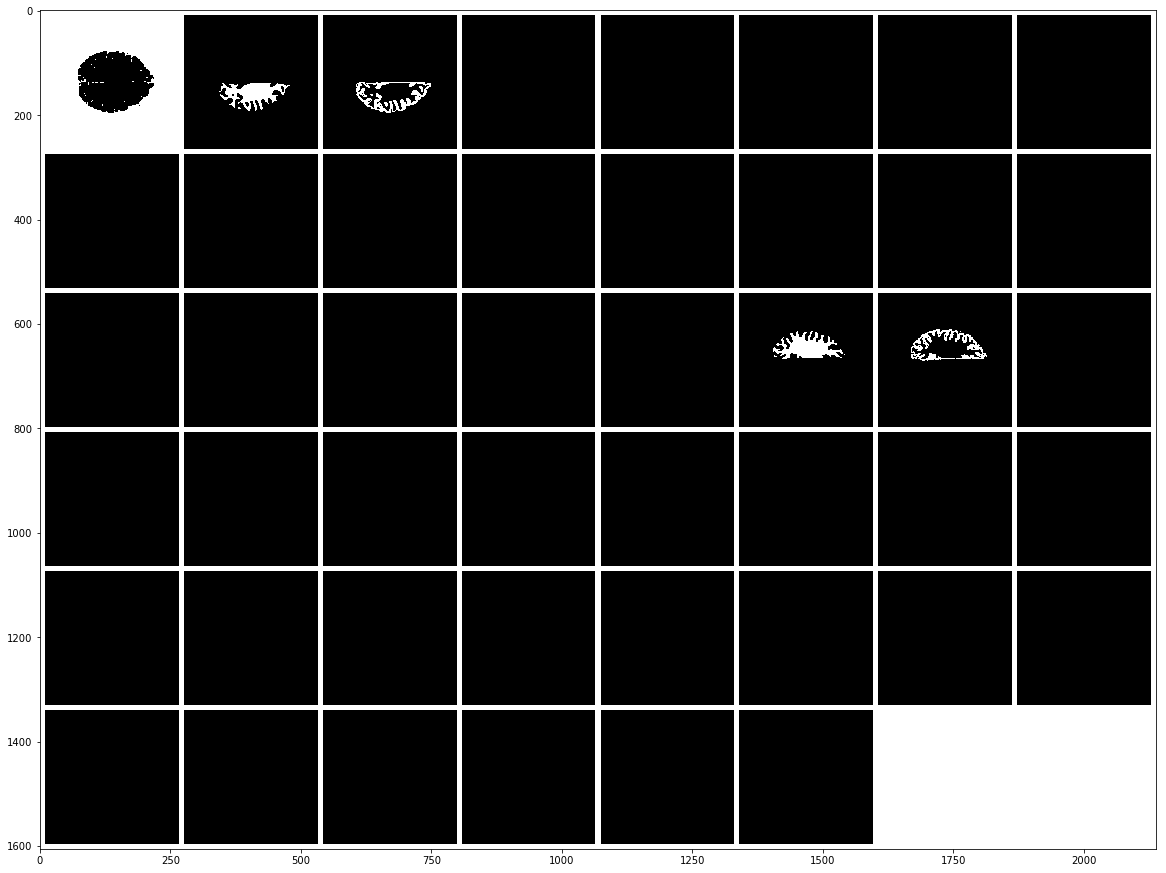

----------------------------------------------------------------------------------------------------
Ground Truth


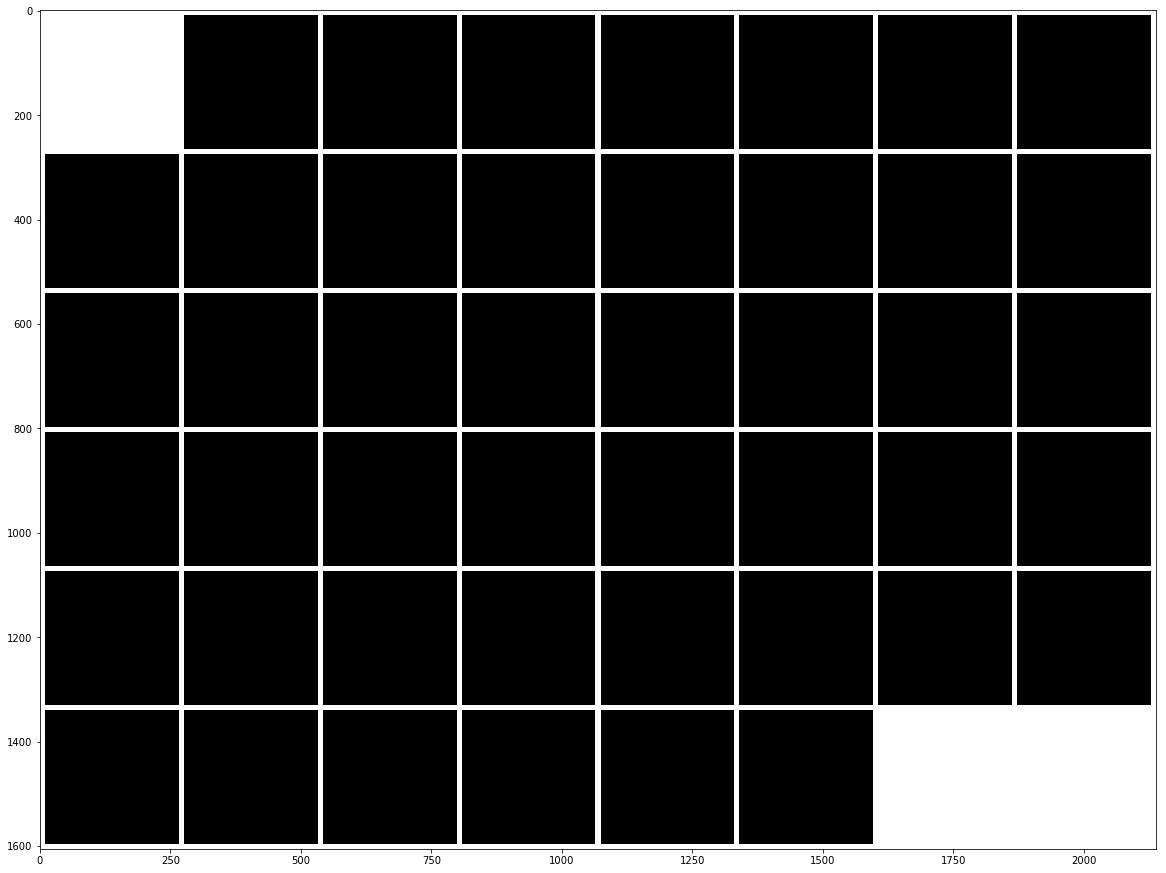

----------------------------------------------------------------------------------------------------
Prediction


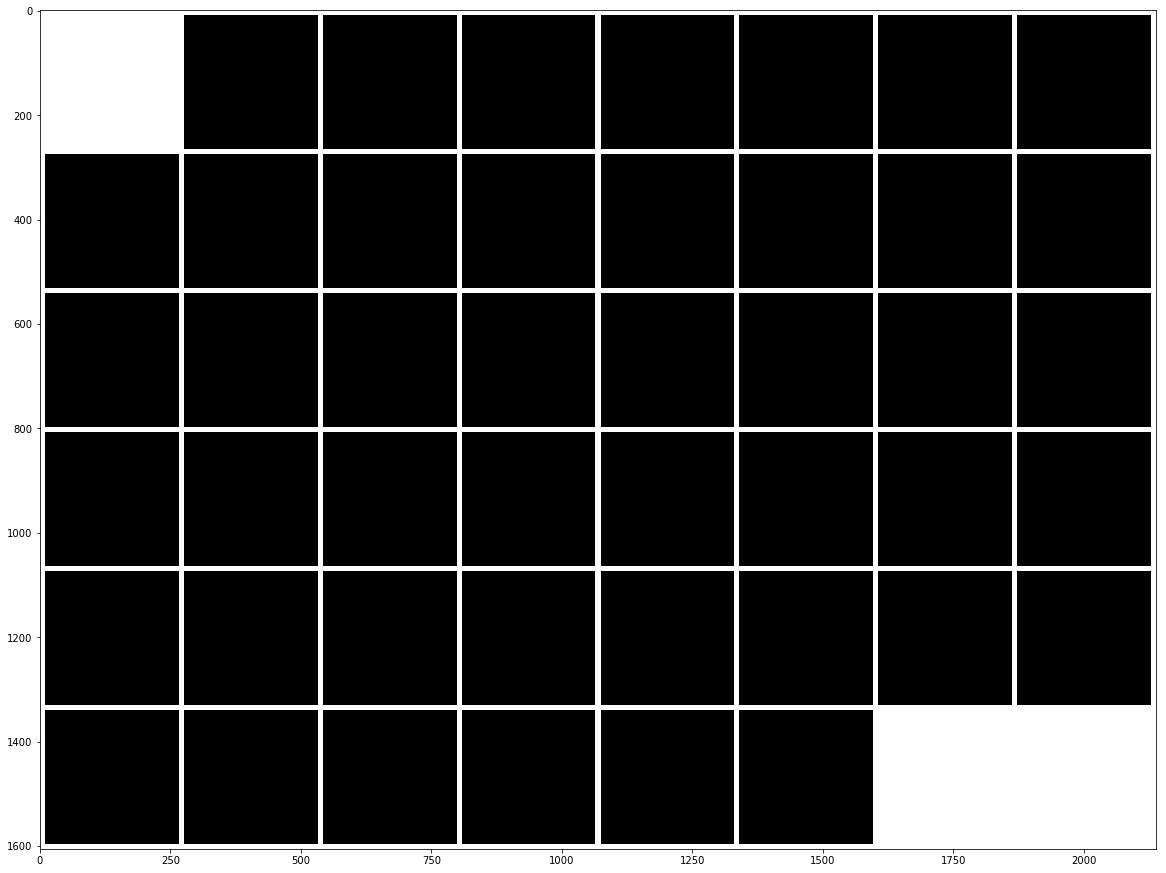

----------------------------------------------------------------------------------------------------
Ground Truth


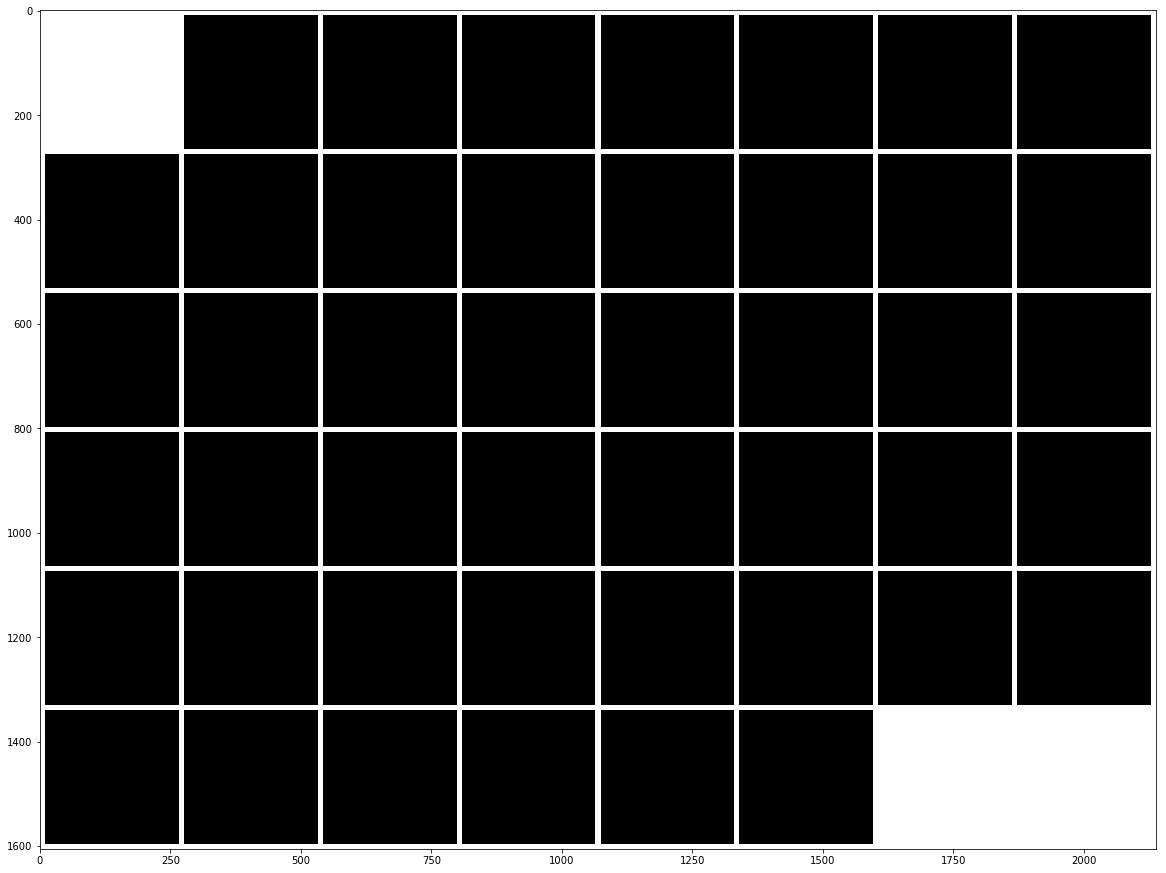

----------------------------------------------------------------------------------------------------
Prediction


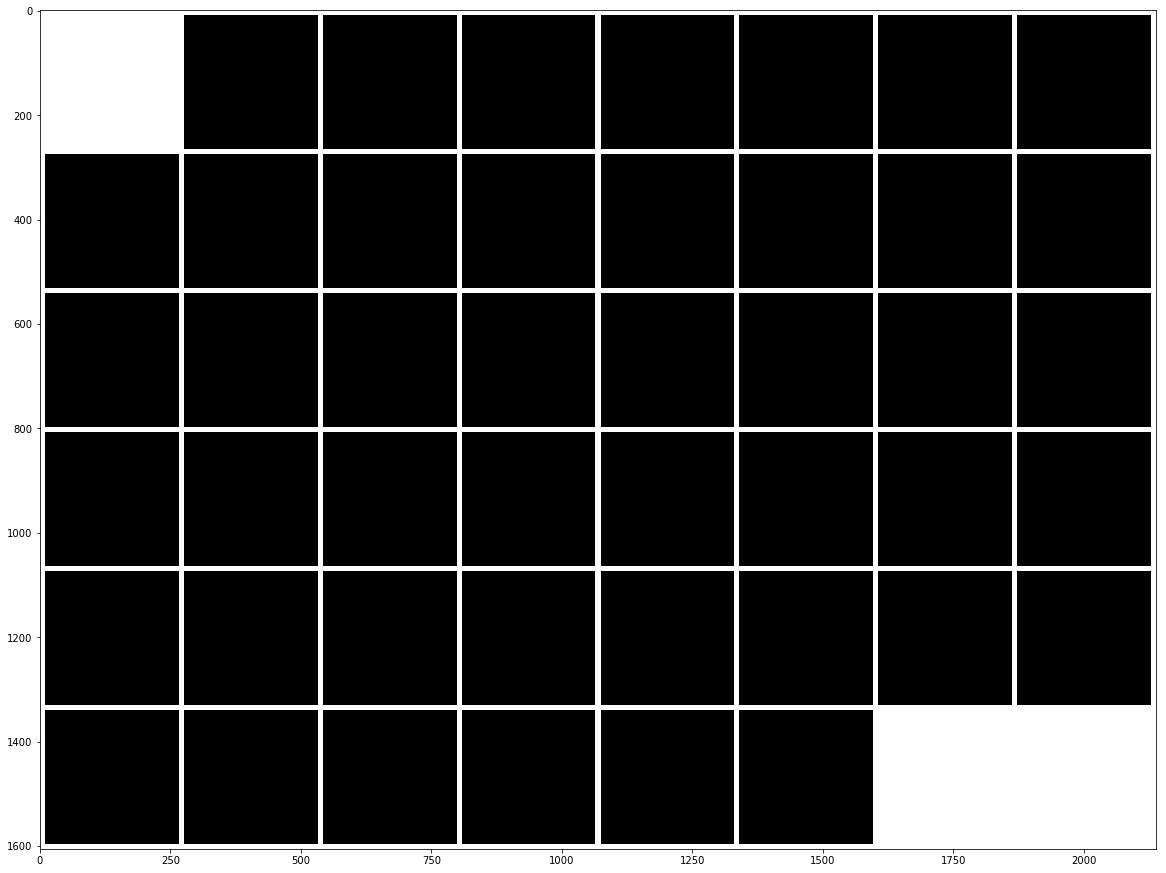

----------------------------------------------------------------------------------------------------
Ground Truth


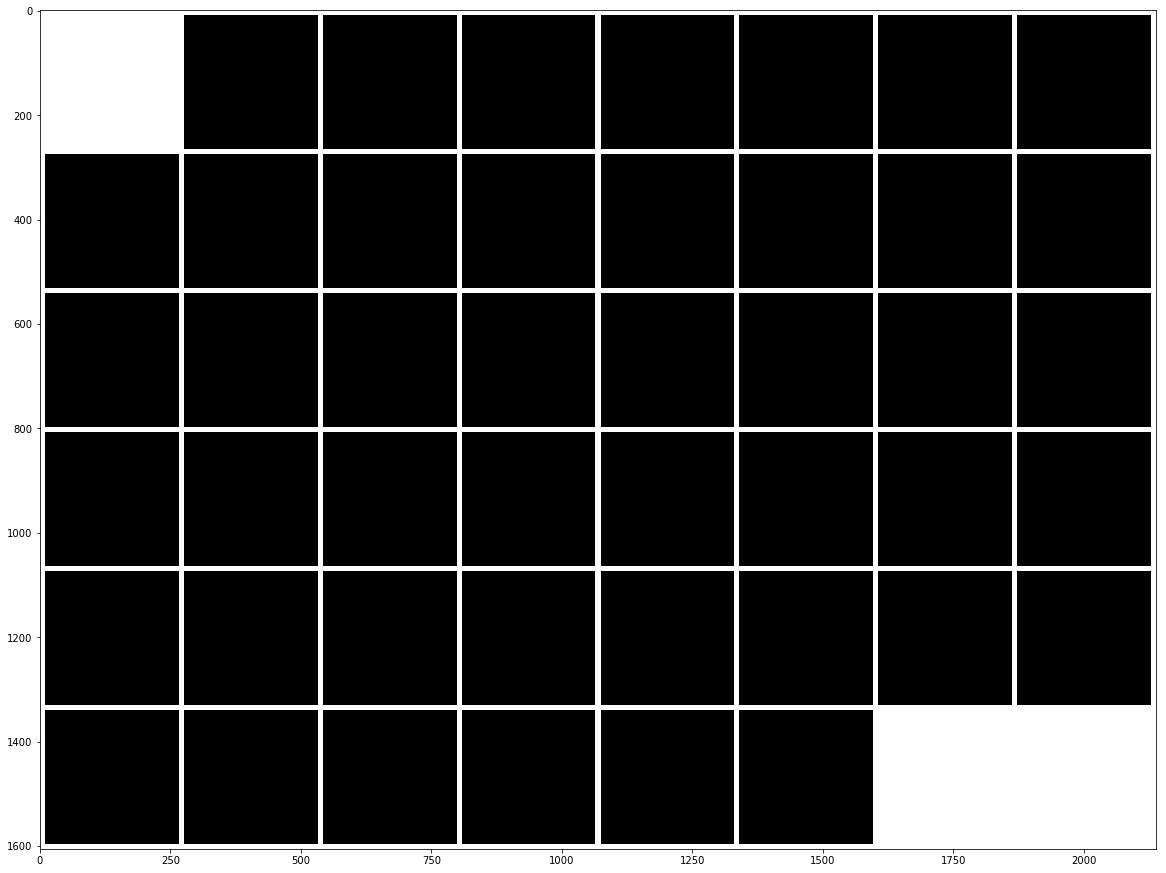

----------------------------------------------------------------------------------------------------
Prediction


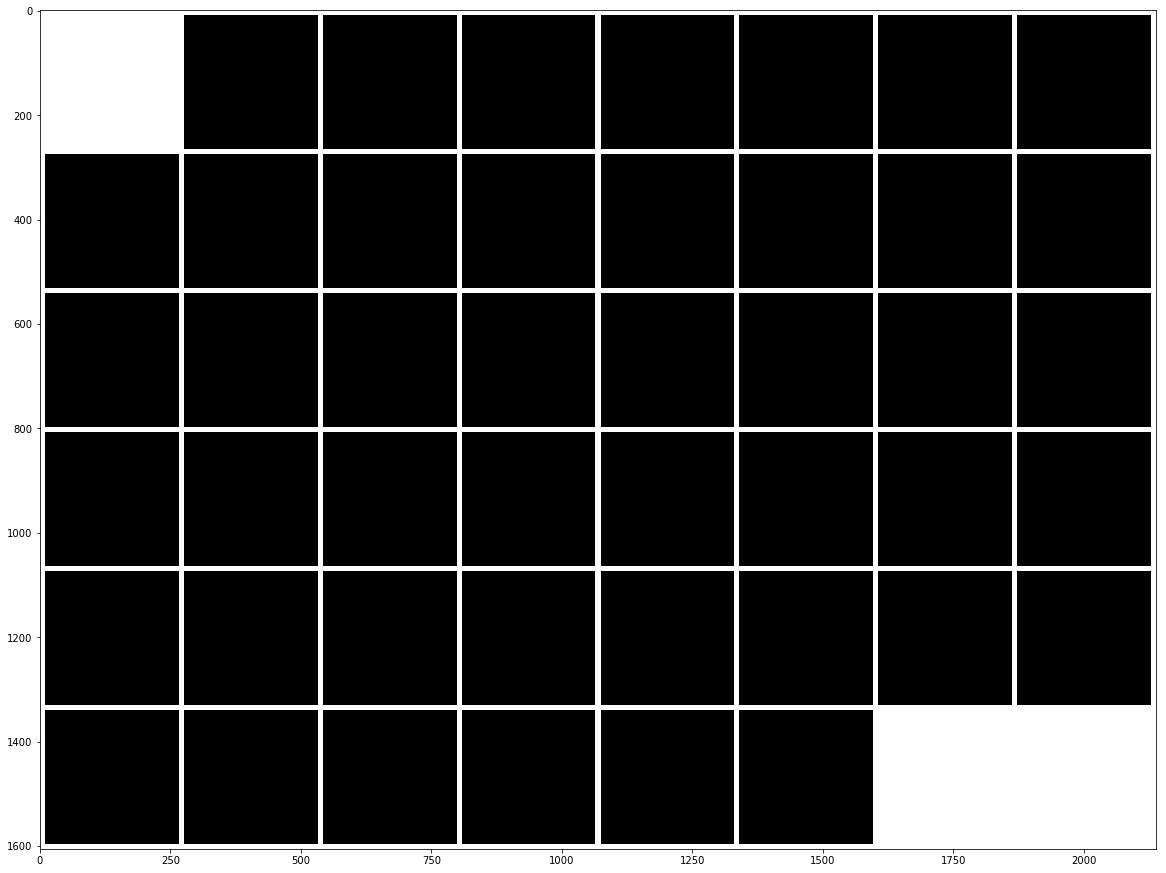

----------------------------------------------------------------------------------------------------
Ground Truth


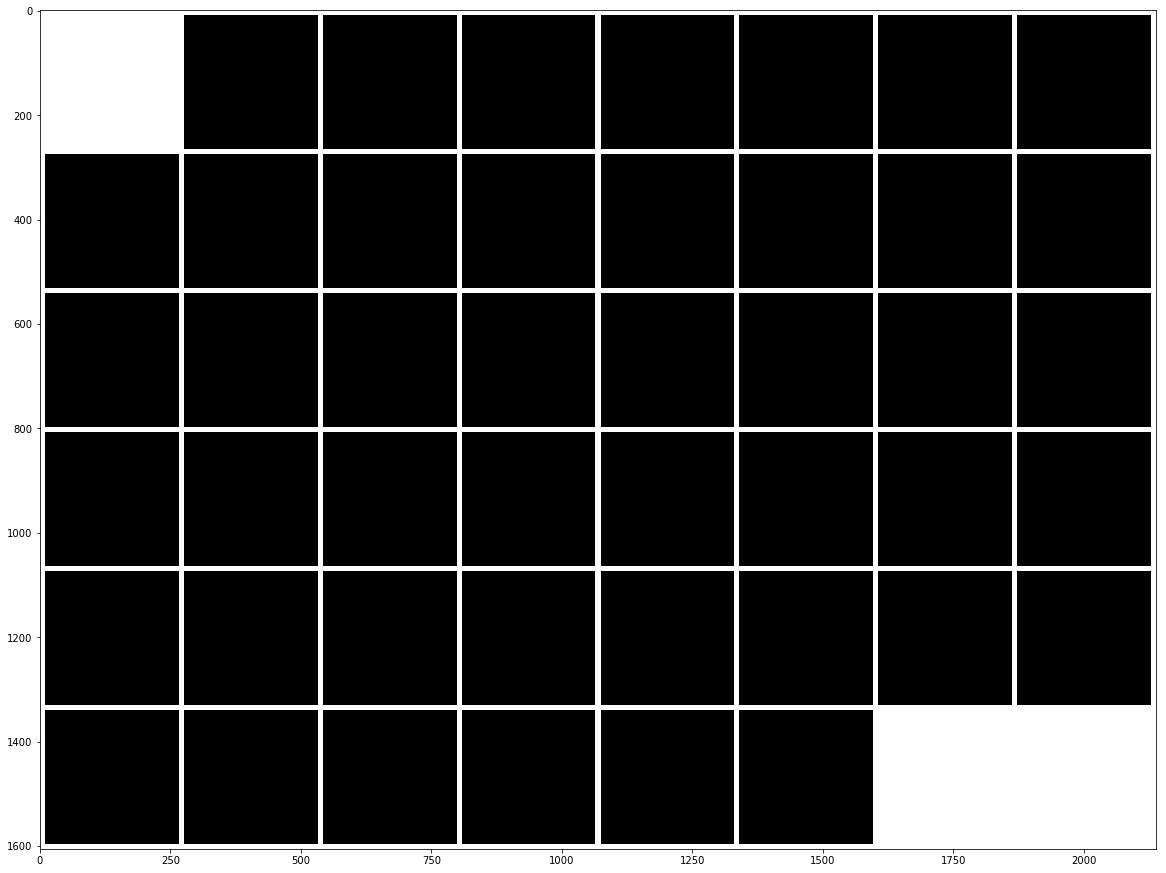

----------------------------------------------------------------------------------------------------
Prediction


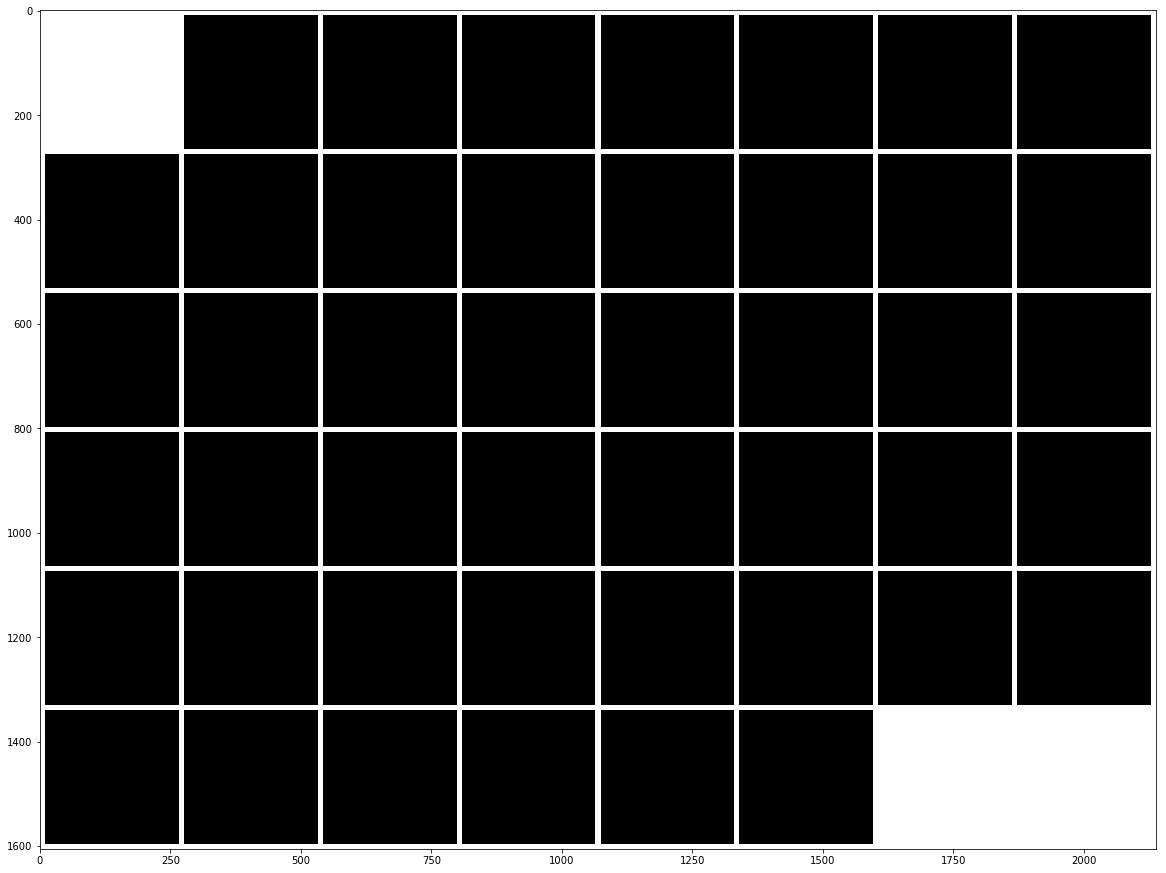

----------------------------------------------------------------------------------------------------
Ground Truth


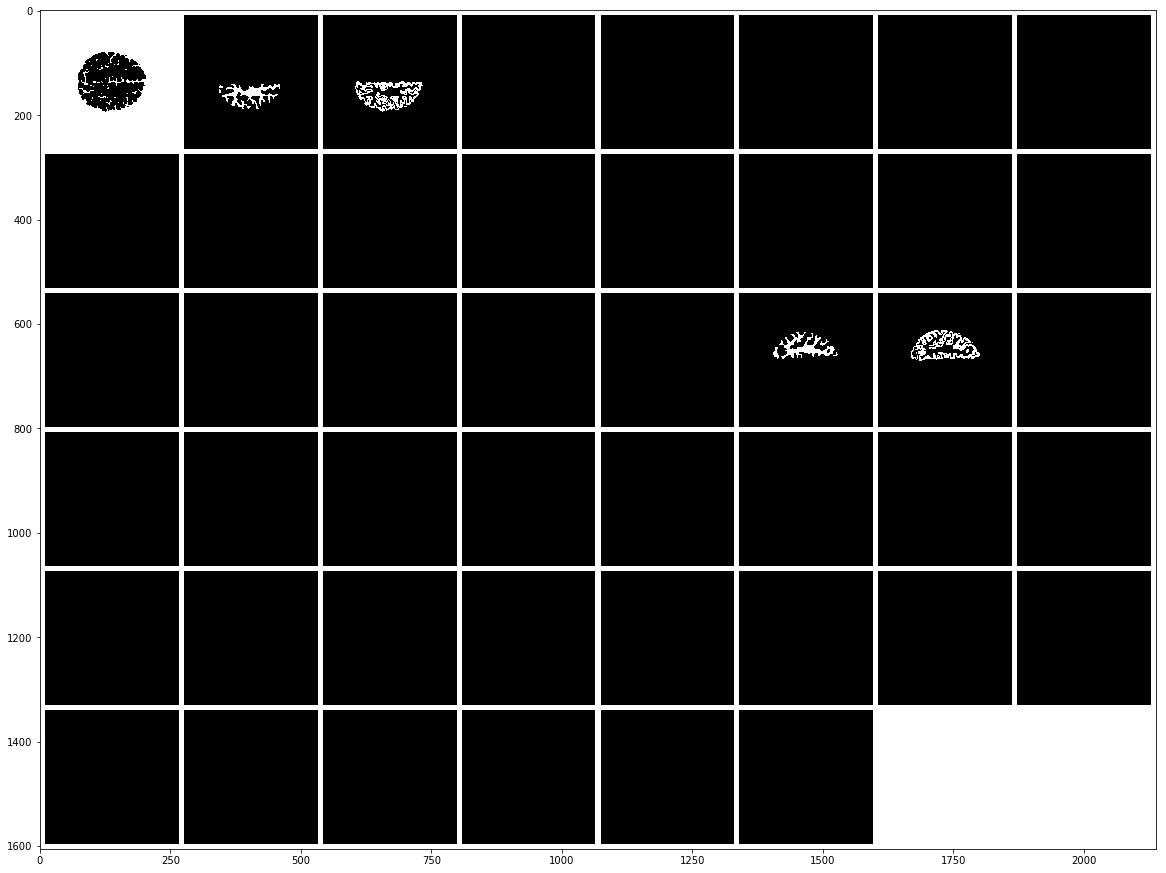

----------------------------------------------------------------------------------------------------
Prediction


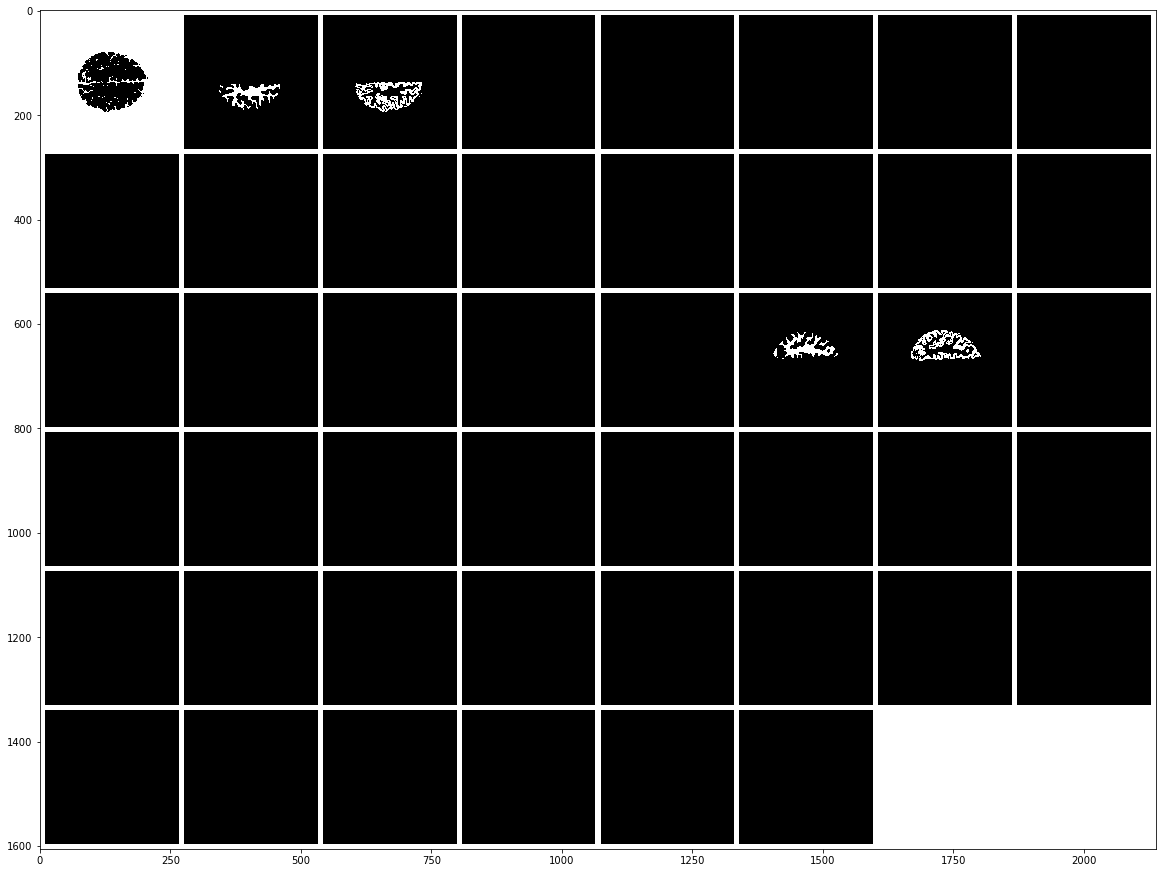

----------------------------------------------------------------------------------------------------
Ground Truth


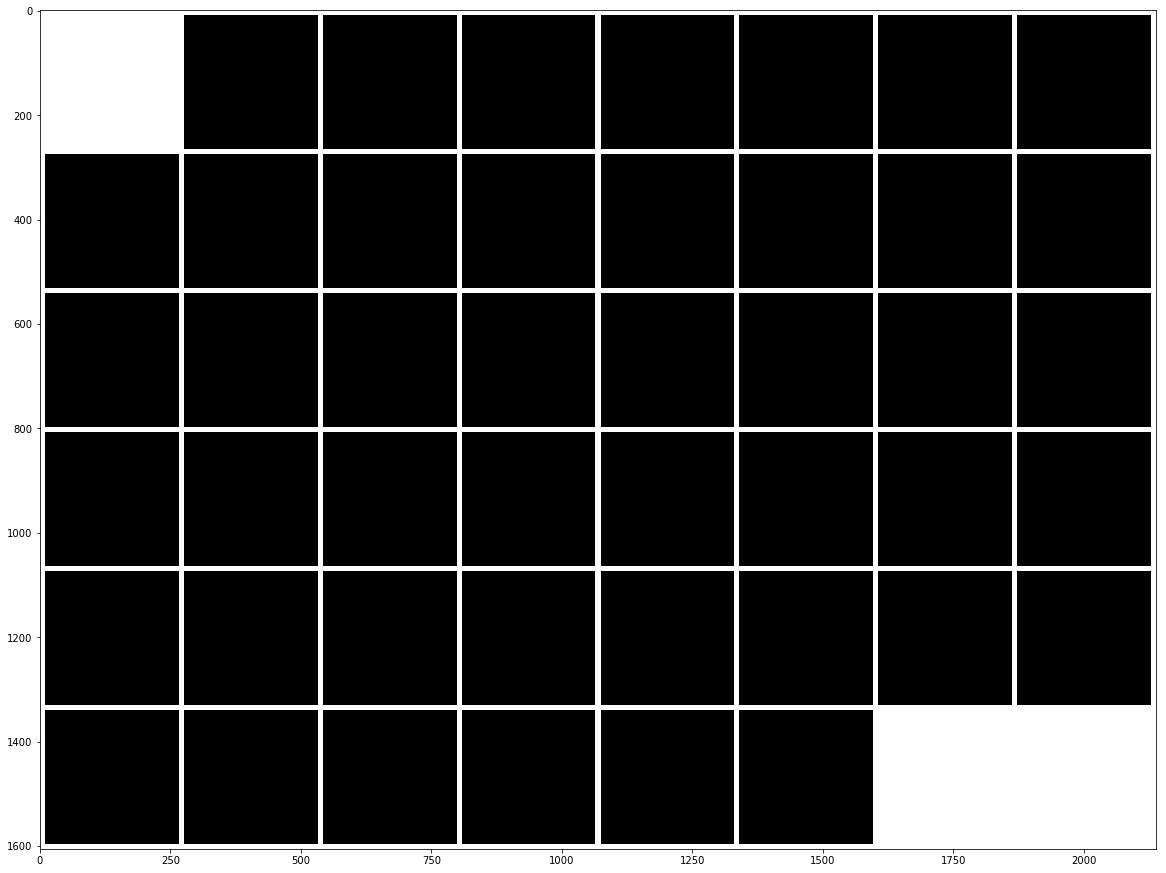

----------------------------------------------------------------------------------------------------
Prediction


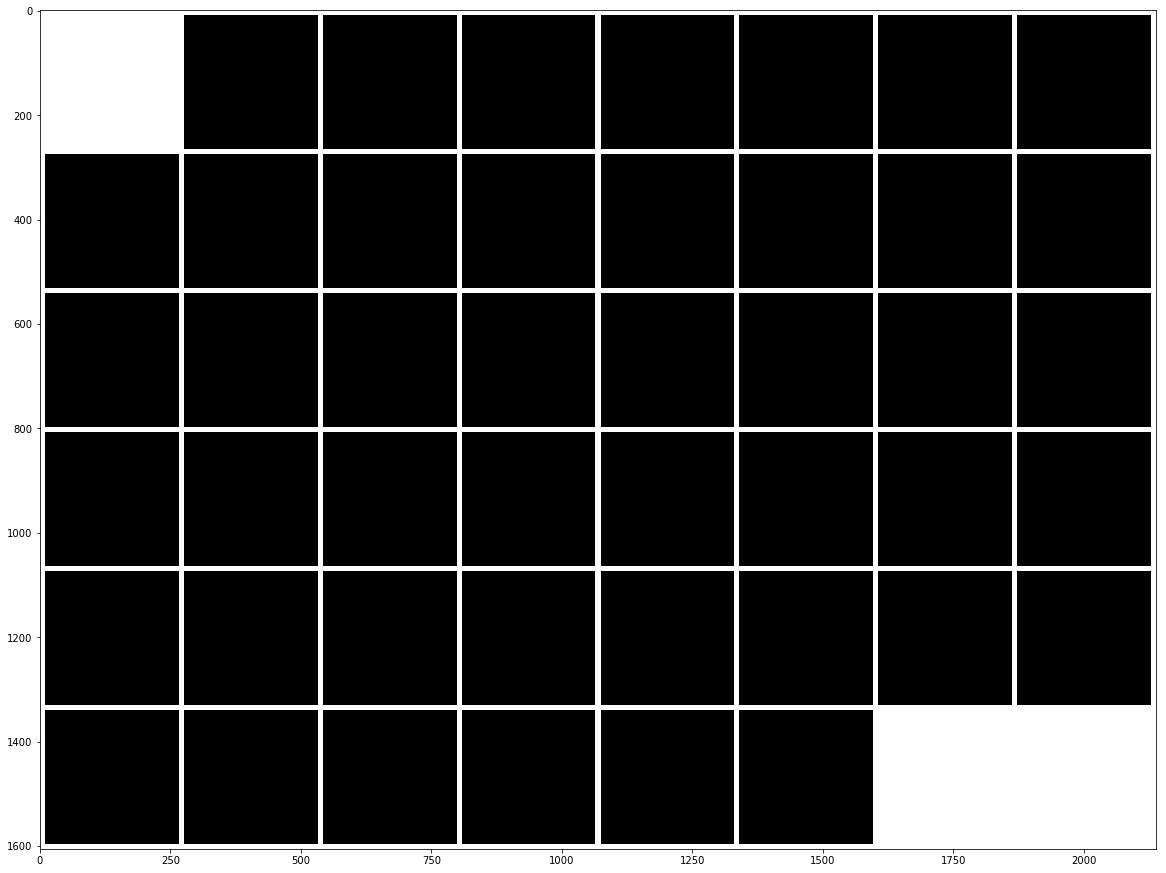

In [35]:
data = next(iter(dataloader["validate"]))
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)
for i in range(11):
    print('-'*100)
    print('Ground Truth')
    abc = data['y'][i,:,:,:]
    bcd = abc.resize(46,1,256,256)
    show(make_grid(bcd,padding=10,pad_value=1)) 
    print('-'*100)
    print('Prediction')
    show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))
    
    